# Librerias 


In [714]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import numpy as np
import plotly.express as px

#Modelo Lineal
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
#Metricas para evaluar modelos
from sklearn import metrics

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importación de Datasets

In [715]:
url_train = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/master/hotels_train.csv'
url_test = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/master/hotels_test.csv'
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

In [716]:
df_train.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,9.0,NaN,0,Transient,115.5,0,1,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,NaN,0,Transient,42.0,1,0,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0


In [717]:
df_hotels_train = df_train.copy()
df_hotels_test = df_test.copy()

# Funciones auxiliares

In [718]:
def showBarPlot(column: str, title: str, x_label: str, y_label: str, alpha = 0.5, showPercentage = False, df_hotels = df_hotels_train) -> None: 
  if (showPercentage):
    data = df_hotels[column].value_counts(normalize=True) * 100
    x = data.index
  else: 
    data = df_hotels[column].value_counts()


  if (column == "arrival_date_month"):
    x = data.index.str.slice(stop=3)

  ax = sns.barplot(x=x, y=data.values, alpha=alpha)

  if (showPercentage):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom')

  ax.set(title = title, ylabel = y_label, xlabel = x_label)
  plt.show()

In [719]:
from textwrap import dedent
showBarPlot.__doc__ = dedent("""\
    Muestra un gráfico de barras con porcentages en las barras con respecto al total del dataset.

    Parámetros
    -------
    - ``column`` (str): Nombre de la columna.
    - ``title`` (str): Titulo gráfico.
    - ``x_label`` (str): Nombre eje x.
    - ``y_label`` (str): Nombre eje y.
    - ``alpha`` (float or int): Transpariencia de las barras.
    - ``showPercentage`` (bool): Indica si se desea mostrar los porcentages de las barras.
    - ``df_hotels`` (DataFrame): DataFrame a graficar.

    Retorna
    -------
    None
  """)

In [720]:
import datetime
def weekNumberToMonth(year: int, week_number: int) -> str : 
  """
    Convierte el número  de semana del año en un mes
    Parámetros 
    -------
    year (int) : Año 
    week_number (int) : Numero de semana a convertir

    Retorna
    -------
    El Mes abreviado en 3 letras
  """
  date = datetime.datetime.strptime(f'{year}-W{week_number}-1', '%Y-W%W-%w')
  return date.strftime('%B')[:3]

def sortByMonth(df) -> None :
  """
    Ordena la columna de meses de menor a mayor. El dataset debe contener una columna llamada arrival_date_month, que contenga los meses abreviados en 3.
    Parámetros
    -------
    df (DataFrame): DataFrame a ordenar

    Retrona
    -------
    None
  """
  months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
  df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=months, ordered=True)
  df.sort_values('arrival_date_month', inplace=True)

In [721]:
def cramers_v(categorical_var1: pd.Series, categorical_var2: pd.Series) -> float:
    """
    Calcula el coeficiente de Cramér's V entre dos variables categóricas.

    Parámetros:
    - categorical_var1: Serie de Pandas que representa la primera variable categórica.
    - categorical_var2: Serie de Pandas que representa la segunda variable categórica.

    Devuelve:
    - Coeficiente de Cramér's V (float) que mide la asociación entre las dos variables categóricas.
    """

    confusion_matrix = pd.crosstab(categorical_var1,categorical_var2)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [722]:
def showFamilyRegister():
  """
   Imprime por pantalla los registros de las familias
  """
  cantidad_reservas_sin_adultos = df_hotels_train[df_hotels_train['adults'] == 0].shape[0]
  print(f'Cantidad de reservas sin adultos: {cantidad_reservas_sin_adultos}')

  cantidad_reservas_sin_adultos_con_hijos = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] != 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y con hijos: {cantidad_reservas_sin_adultos_con_hijos}')

  cantidad_reservas_sin_adultos_sin_hijos = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] == 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y sin hijos: {cantidad_reservas_sin_adultos_sin_hijos}')

  cantidad_reservas_sin_adultos_con_hijos_con_bebes = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] != 0) & (df_hotels_train['babies'] != 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y sin hijos y con bebes: {cantidad_reservas_sin_adultos_con_hijos_con_bebes}')
  cantidad_reservas_sin_adultos_sin_hijos_sin_bebes = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] == 0)& (df_hotels_train['babies'] == 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y sin hijos y sin bebes: {cantidad_reservas_sin_adultos_sin_hijos_sin_bebes}')

# 1) Análisis Exploratorio y Preprocesamiento de Datos


 ## Análisis del tipo de variable

In [723]:
print(df_hotels_train.shape)
df_hotels_train.dtypes

(61913, 32)


hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           

### Datos a analizar para la ingenieria de datos
Variables a revisar
- Adults: Ver caso en el que no hay adultos 
- Meals: Cambiar Undefined por SC (en el paper especifica que son lo mismo)
- Children: pasar a int
- adr: casos negativos

#### `hotel`
  - Descripción: Nombre del Hotel
  - Tipo de dato: Cualitativa
  - Valores posibles: City Hotel, Resort Hotel 
  - Frecuencia: City Hotel 68.05% , Resort Hotel 31,95%
 

In [724]:
# Valores posibles
df_hotels_train['hotel'].unique()

array(['City Hotel', 'Resort Hotel'], dtype=object)

In [725]:
#Frecuencia de los valores posibles
round(df_hotels_train['hotel'].value_counts(normalize=True) * 100, 2)

City Hotel      68.05
Resort Hotel    31.95
Name: hotel, dtype: float64

##### Distribución


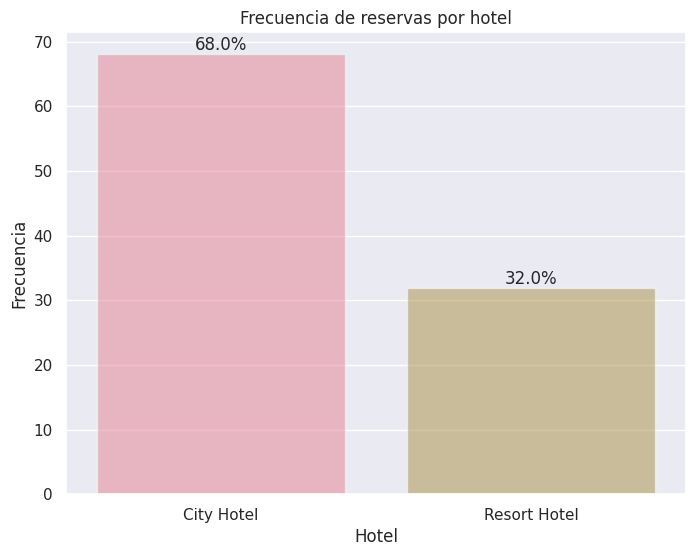

In [726]:
showBarPlot('hotel', "Frecuencia de reservas por hotel", x_label= 'Hotel', y_label="Frecuencia", showPercentage = True)

Con el gráfico de distribucion de las reservas por hotel, podemos observar que en la maoyría de los casos las reservas son para "City Hotel" y el restante para "Resort Hotel". 

Del 100% de las reservas, que en total son 61913, 42100 pertenecen al hotel _City_ y las 19812 reservas restantes pertenecen al hotel _Resort_.

#### --------------------------------------------------------------------------

#### `lead_time`
  - Descripción: Diferencia de dias entre la compra de la reserva y la alojamiento del cliente
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_



In [727]:
# Medidas
round(df_hotels_train['lead_time'].describe(), 2)

count    61913.00
mean       112.25
std        110.72
min          0.00
25%         23.00
50%         78.00
75%        172.00
max        629.00
Name: lead_time, dtype: float64

- ##### Distribución


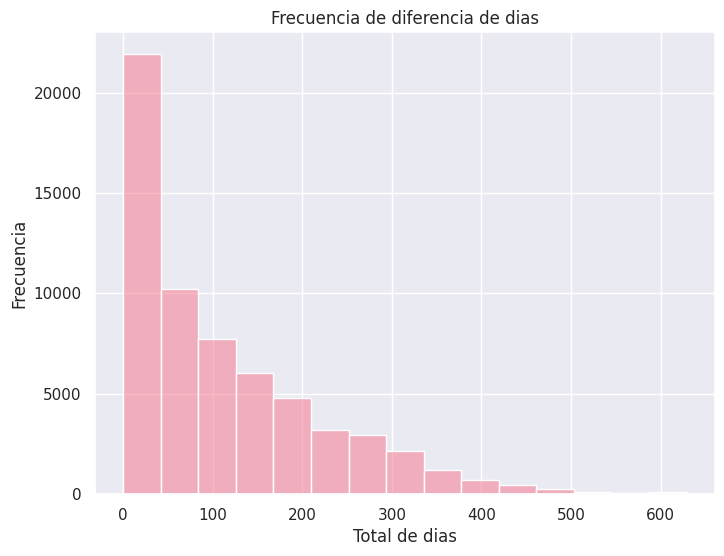

In [728]:
sns_hist=sns.histplot(data=df_hotels_train['lead_time'], alpha = 0.5, bins = 15).set(title="Frecuencia de diferencia de dias", xlabel="Total de dias", ylabel="Frecuencia")

Podemos analizar que mayormente la diferencia de días entre que se efectua la reserva y el cliente se aloja, es menor a los 25 días.

#### --------------------------------------------------------------------------

#### Variables de fecha de llegada
  - `arrival_date_year`
    - Descripcion: Año de llegada
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-años)
    - Distribución: _ver en código_
  - `arrival_date_month`
    - Descripcion: Mes de llegada
    - Tipo de dato: Cualitativa
    - Valores posibles: Todos los meses
    - Frecuencia: [ver en código](#info-meses)
  - `arrival_date_week_number`
    - Descripcion: Número de semana de la fecha de llegada. Es con respecto al año, no al mes.
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-numero-semana-año)
    - Distribución: _ver en código_
  - `arrival_date_day_of_month`
    - Descripcion: Número del dia del mes de la fecha de llegada.
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-numero-dia-mes)
    - Distribución: _ver en código_

<a name="info-años"> </a>
##### Información de _**los años**_

  - ###### Medidas

In [729]:
# Medidas de los años
round(df_hotels_train['arrival_date_year'].describe(), 2)

count    61913.00
mean      2016.15
std          0.71
min       2015.00
25%       2016.00
50%       2016.00
75%       2017.00
max       2017.00
Name: arrival_date_year, dtype: float64

- ###### Distribución

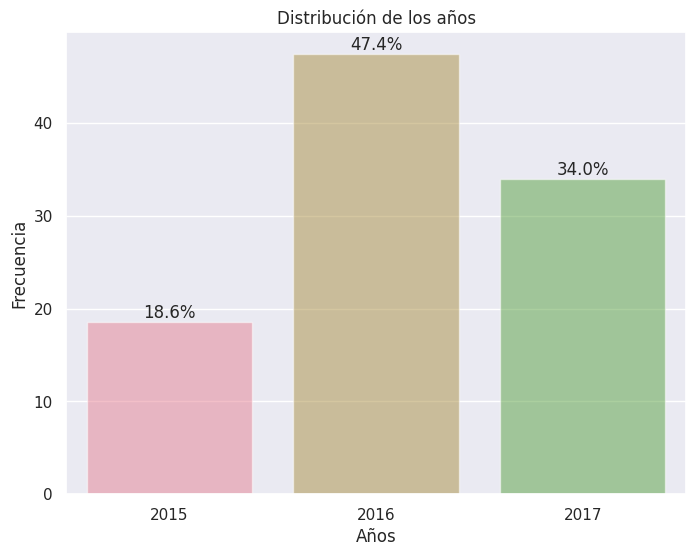

In [730]:
showBarPlot('arrival_date_year', "Distribución de los años", x_label= 'Años', y_label="Frecuencia", showPercentage = True)

Podemos observar en el año 2016 se hicieron la mayoría de las reservas.

<a name="info-meses"> </a>
##### Información de _**los meses**_

- ###### Frecuencia

In [731]:
round(df_hotels_train['arrival_date_month'].value_counts(normalize=True) * 100, 2)

August       11.59
July         10.54
May           9.95
April         9.49
October       9.47
June          9.32
September     9.08
March         7.91
February      6.66
December      5.64
November      5.50
January       4.85
Name: arrival_date_month, dtype: float64

Idea: Agregar una columna que sea arrival_date, que sea de tipo Date (de pandas)

- ###### Distribución


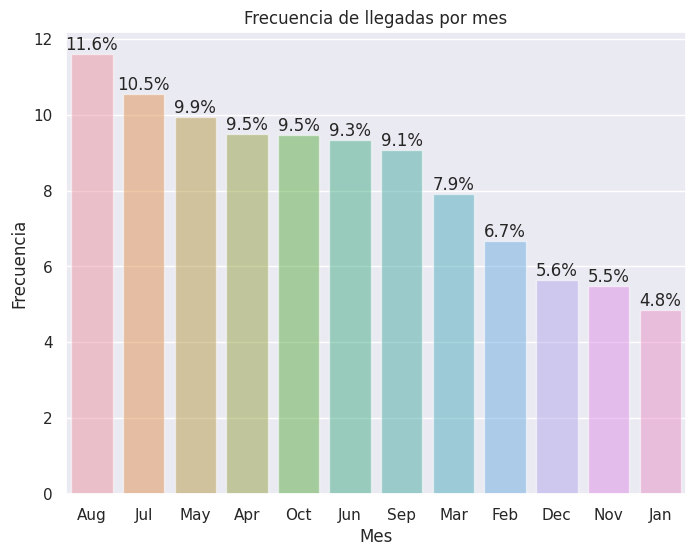

In [732]:
showBarPlot('arrival_date_month', "Frecuencia de llegadas por mes", x_label= 'Mes', y_label="Frecuencia", showPercentage = True)

Podemos observar que la mayoría de las reservas fueron hechas en el mes de Agosto y Julio. Podemos considerar que es en la época de invierno del hemisferio norte.

<a name="info-numero-semana-año"> </a>
##### Información del _**numero de semana del año**_

- ###### Medidas

In [733]:
round(df_hotels_train['arrival_date_week_number'].describe(), 2)

count    61913.00
mean        27.22
std         13.53
min          1.00
25%         16.00
50%         28.00
75%         38.00
max         53.00
Name: arrival_date_week_number, dtype: float64

- ###### Distribución

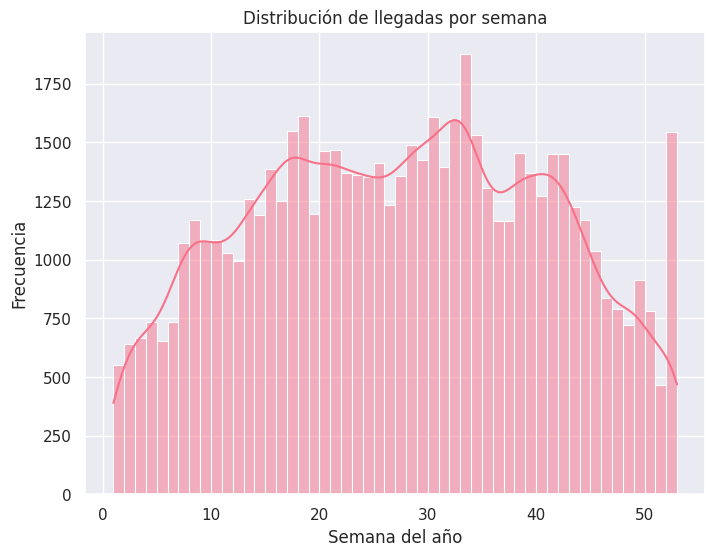

In [734]:
WEEKS_PER_YEAR = 52
histplot = sns.histplot(data = df_hotels_train, x = "arrival_date_week_number", bins = WEEKS_PER_YEAR, kde=True).set(title = "Distribución de llegadas por semana", ylabel = "Frecuencia", xlabel = "Semana del año") 

Podemos observar que entre la semana 31, que sería agosto, y la semana 35, que tambien es agosto, es en donde se produce el pico de reservas. En la última semana del año tambien se registraron muchas reservas.

<a name="info-numero-dia-mes"> </a>
##### Información del _**numero del mes**_

- ###### Medidas

In [735]:
round(df_hotels_train['arrival_date_day_of_month'].describe(), 2)

count    61913.00
mean        15.79
std          8.80
min          1.00
25%          8.00
50%         16.00
75%         23.00
max         31.00
Name: arrival_date_day_of_month, dtype: float64

- ###### Distribución

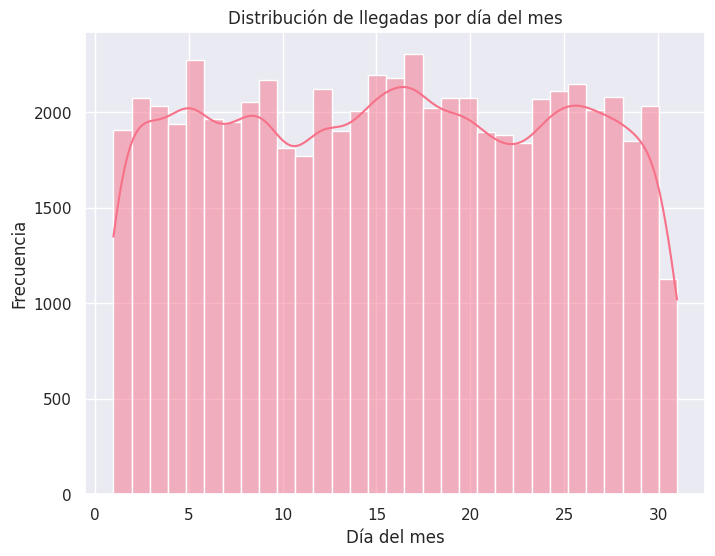

In [736]:
DAYS_PER_MONTH = 31
histplot = sns.histplot(data = df_hotels_train, x = "arrival_date_day_of_month", bins = DAYS_PER_MONTH, kde=True).set(title = "Distribución de llegadas por día del mes", ylabel = "Frecuencia", xlabel = "Día del mes")

Podemos observar que la repartición de reservas segun el día, tiende a ser equitativa.

#### --------------------------------------------------------------------------

#### Variables de cantidad de noches
  - `stays_in_weekend_nights`
    - Descripción: Cuantas noches son en fines de semana  
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-noches-fin-semana)
    - Distribución: _ver en código_
  - `stays_in_weeks_nights`
    - Descripción: Cuantas noches son en días de semana  
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-noches-semana)  
    - Distribución: _ver en código_

<a name="info-noches-fin-semana"> </a>
##### Información de _**la cantidad noches de fin de semana**_

  - ###### Medidas

In [737]:
round(df_hotels_train['stays_in_weekend_nights'].describe(), 2)

count    61913.00
mean         0.92
std          0.99
min          0.00
25%          0.00
50%          1.00
75%          2.00
max         16.00
Name: stays_in_weekend_nights, dtype: float64

- ###### Distribución

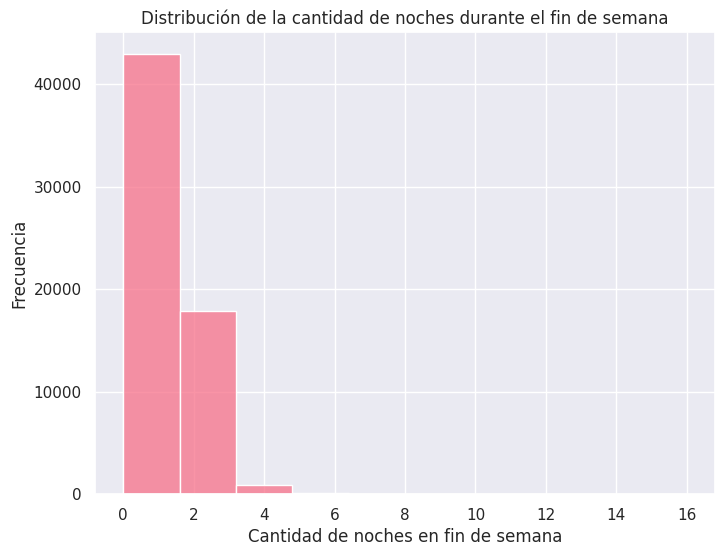

In [738]:
histplot = sns.histplot(data = df_hotels_train, x = "stays_in_weekend_nights", bins = 10).set(title = "Distribución de la cantidad de noches durante el fin de semana", ylabel = "Frecuencia", xlabel = "Cantidad de noches en fin de semana")

La mayoría de los clientes eligen quedarse una noche en el fin de semana

<a name="info-noches-semana"> </a>
##### Información de _**la cantidad noches de semana**_

  - ###### Medidas

In [739]:
round(df_hotels_train['stays_in_week_nights'].describe(), 2)

count    61913.00
mean         2.51
std          1.88
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         40.00
Name: stays_in_week_nights, dtype: float64

- ###### Distribución

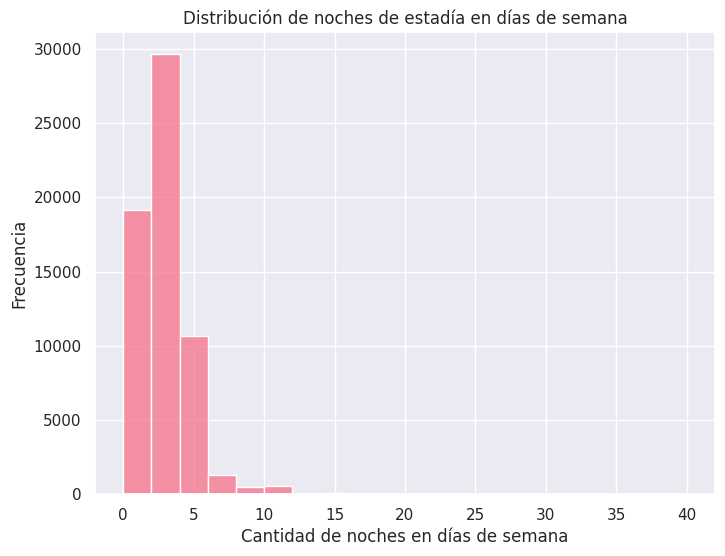

In [740]:
histplot = sns.histplot(data = df_hotels_train, x = "stays_in_week_nights", bins = 20).set(title = "Distribución de noches de estadía en días de semana", ylabel = "Frecuencia", xlabel = "Cantidad de noches en días de semana")

Podemos observar que la mayoría de los clientes reservan aproximadamente entre 1 y 5 noches que son en dia de semana.

#### --------------------------------------------------------------------------

#### `adults`
  - Descripción: Cantidad de adultos en la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_ 


  - ###### Medidas

In [741]:
round(df_hotels_train['adults'].describe(), 2)

count    61913.00
mean         1.86
std          0.59
min          0.00
25%          2.00
50%          2.00
75%          2.00
max         55.00
Name: adults, dtype: float64

  - ###### Distribución

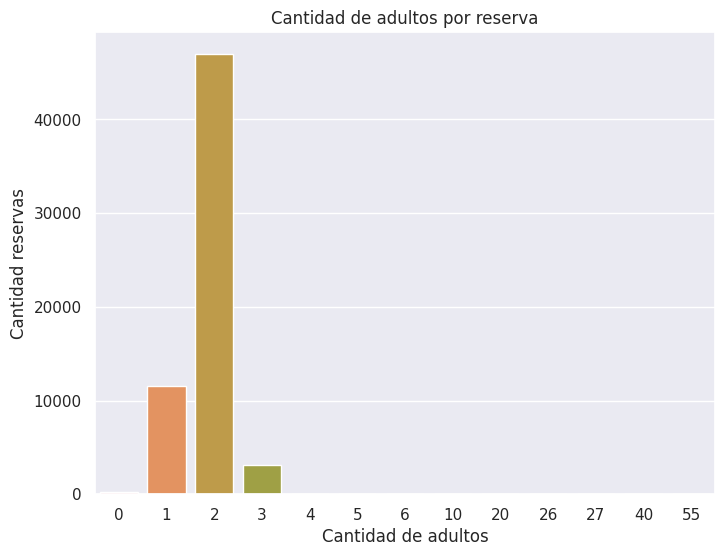

In [742]:
plot = sns.countplot(x='adults', data=df_hotels_train).set(title = "Cantidad de adultos por reserva", ylabel = "Cantidad reservas", xlabel = "Cantidad de adultos")

En la mayoría de las reservas, se registraron 2 adultos. Y en un caso particular no se registraron adultos.

#### --------------------------------------------------------------------------

#### `children`
  - Descripción: Cantidad de niños en la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [743]:
round(df_hotels_train['children'].describe(), 2)

count    61909.0
mean         0.1
std          0.4
min          0.0
25%          0.0
50%          0.0
75%          0.0
max         10.0
Name: children, dtype: float64

  - ###### Distribución

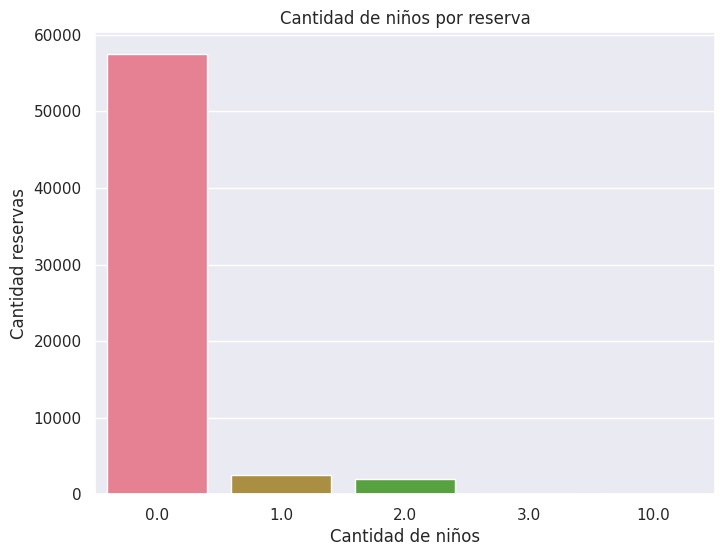

In [744]:
plot = sns.countplot(x='children', data=df_hotels_train).set(title = "Cantidad de niños por reserva", ylabel = "Cantidad reservas", xlabel = "Cantidad de niños")

La mayoría de las reservas no alojan niños.

#### --------------------------------------------------------------------------

#### `babies`
  - Descripción: Cantidad de bebes en la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [745]:
round(df_hotels_train['babies'].describe(), 2)

count    61913.00
mean         0.01
std          0.09
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          9.00
Name: babies, dtype: float64

  - ###### Distribución

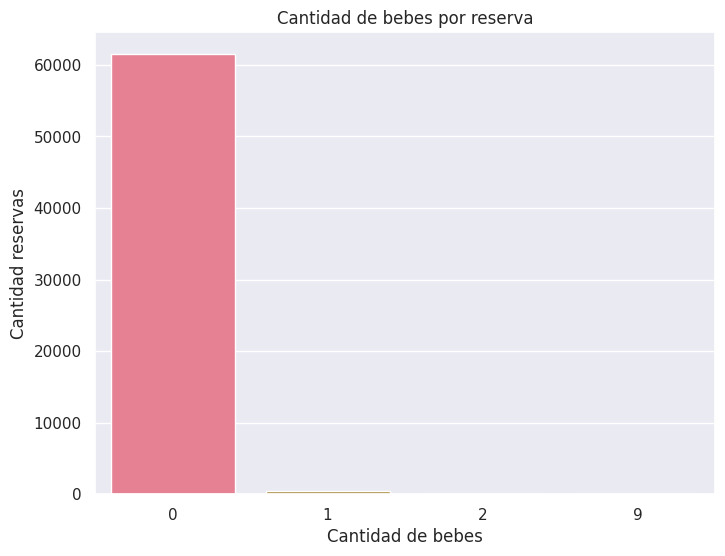

In [746]:
plot = sns.countplot(x='babies', data=df_hotels_train).set(title = "Cantidad de bebes por reserva", ylabel = "Cantidad reservas", xlabel = "Cantidad de bebes")

Al igual que con los niños, la mayoría no registro bebes. 

#### --------------------------------------------------------------------------

#### `meal`
  - Descripción: Comidas que el cliente solicito
  - Tipo de dato: Cualitativas
  - Valores posibles: BB, HB, SC/UNDEFINED, FB
  - Frecuencia: _ver en código_ 


- ###### Frecuencia


In [747]:
round(df_hotels_train['meal'].value_counts(normalize=True) * 100, 2)

BB           77.26
HB           12.04
SC            8.97
Undefined     0.95
FB            0.77
Name: meal, dtype: float64

- ###### Distribución


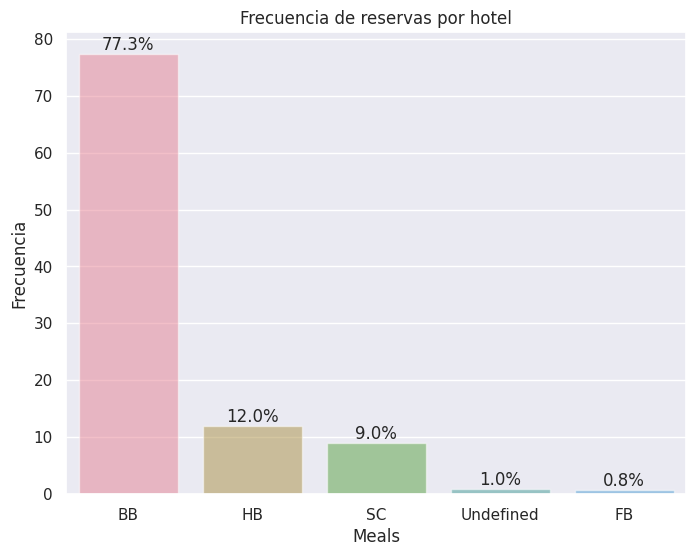

In [748]:
showBarPlot('meal', "Frecuencia de meals", x_label= 'Meals', y_label="Frecuencia", showPercentage = True)

La mayoría de las reservas registraron que el cliente quiere el paquete de BB (Bed & Breakfast)

#### --------------------------------------------------------------------------

#### `country`
  - Descripción: Pais de origen de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [749]:
#Valores posibles
df_hotels_train['country'].unique()

array(['USA', 'PRT', 'CHE', 'FRA', 'AGO', 'GBR', 'DEU', 'ESP', 'ROU',
       'SWE', 'IRL', 'CN', 'ITA', 'NLD', 'NOR', 'MAR', 'IND', 'BEL',
       'ISR', 'KOR', 'TUN', 'JPN', 'FIN', 'TUR', 'CHN', 'AUT', 'ZAF',
       'LUX', 'BRA', 'POL', 'DNK', 'IRN', 'RUS', 'VEN', 'SEN', 'AUS',
       'MLT', 'BGR', 'THA', 'GEO', 'SRB', 'PHL', 'ARG', 'LVA', 'LTU',
       'ARE', nan, 'VNM', 'MOZ', 'MEX', 'HUN', 'DZA', 'GAB', 'UKR', 'SVN',
       'HRV', 'SVK', 'CHL', 'BLR', 'CPV', 'CRI', 'EST', 'TWN', 'ALB',
       'SGP', 'PRI', 'IDN', 'DOM', 'MUS', 'OMN', 'EGY', 'SAU', 'NZL',
       'FRO', 'CYP', 'PER', 'CZE', 'GRC', 'ARM', 'COL', 'PAK', 'MDG',
       'HKG', 'MYS', 'MKD', 'ISL', 'BIH', 'NGA', 'AZE', 'MAC', 'JEY',
       'SUR', 'KWT', 'BGD', 'IRQ', 'MDV', 'GGY', 'VGB', 'ECU', 'URY',
       'ETH', 'LBN', 'BOL', 'QAT', 'JOR', 'COM', 'GNB', 'MYT', 'UGA',
       'BEN', 'GIB', 'KAZ', 'TZA', 'LBY', 'SYC', 'PRY', 'MNE', 'ZWE',
       'CAF', 'ATA', 'MWI', 'JAM', 'AND', 'LIE', 'FJI', 'TJK', 'LKA',
       'HND', 'P

- ###### Frecuencia


In [750]:
round(df_hotels_train['country'].value_counts(normalize=True) * 100, 2)

PRT    45.31
GBR     9.29
FRA     7.80
ESP     6.82
DEU     5.37
       ...  
HND     0.00
FJI     0.00
LIE     0.00
ATA     0.00
RWA     0.00
Name: country, Length: 149, dtype: float64

- ###### Distribución


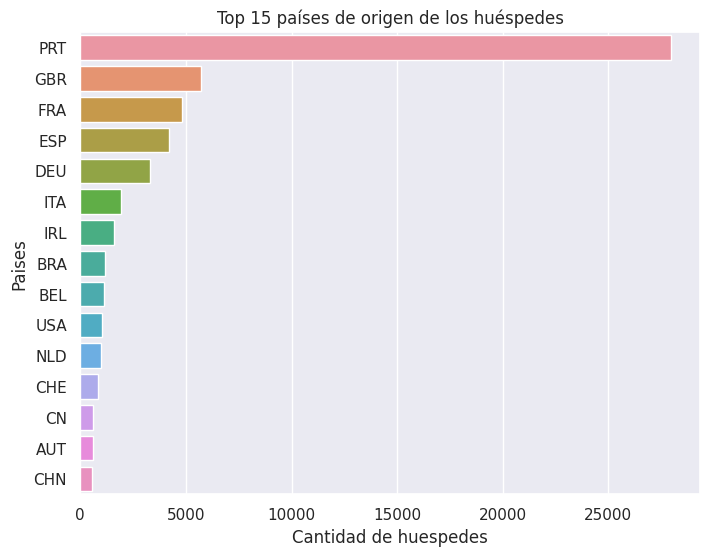

In [751]:
top_countries = df_hotels_train['country'].value_counts().nlargest(15)

top_countries_index = top_countries.index

df_top_countries = df_hotels_train[df_hotels_train['country'].isin(top_countries_index)]

plot = sns.countplot(y='country', data=df_top_countries, order=top_countries_index).set(title = "Top 15 países de origen de los huéspedes", ylabel = "Paises", xlabel = "Cantidad de huespedes")

La mayoría de clientes que efectuaron reservas, provienen de Portugal.

Al ser casi todos los paises, el gráfico la distribución se volvia inentendible, por lo tanto decidimos acotarlo con los 15 paises más registrados.

#### --------------------------------------------------------------------------

#### `market_segment`
  - Descripción: Designación del segmento del mercado
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [752]:
#Valores posibles
df_hotels_train['market_segment'].unique()

array(['Online TA', 'Groups', 'Offline TA/TO', 'Direct', 'Complementary',
       'Corporate', 'Aviation', 'Undefined'], dtype=object)

- Direct: La reserva fue hecha directamente con el hotel.
- Corporate : La reserva fue hecha por una empresa.
- Online TA: La reserva se concreto a través de una agencia de viajes activa.
- Offline TA/TO: La reserva fue hecha a través de una agencia de viajes que no se encuentra disponible o un operador turístico.
- Complementary: La reserva fue hecha como complemento de otra reserva previa.
- Groups: La reserva fue hecha como parte de un grupo .

- ###### Frecuencia


In [753]:
round(df_hotels_train['market_segment'].value_counts(normalize=True) * 100, 2)

Online TA        47.27
Offline TA/TO    20.00
Groups           18.65
Direct            9.30
Corporate         4.01
Complementary     0.58
Aviation          0.18
Undefined         0.00
Name: market_segment, dtype: float64

- ###### Distribución


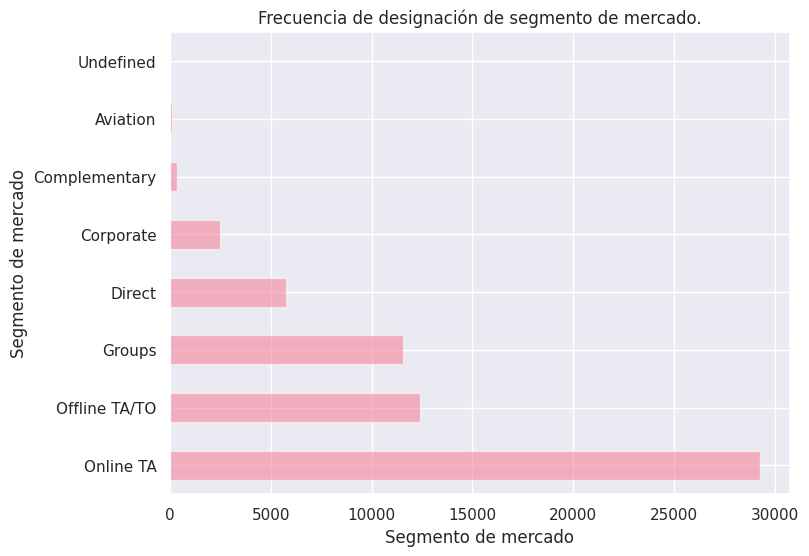

In [754]:
grf=df_hotels_train['market_segment'].value_counts().plot.barh(alpha=0.5, title="Frecuencia de designación de segmento de mercado.",xlabel='Segmento de mercado',ylabel='Segmento de mercado')  

La distribución se reparte entre 3 categorias mayormente: 
1. Online TA (Travel Agents)
2. Offline TA/TO
3. Groups

#### --------------------------------------------------------------------------

#### `distribution_channel`
  - Descripción: Canal de distribución de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [755]:
#Valores posibles
df_hotels_train['distribution_channel'].unique()

array(['TA/TO', 'Direct', 'Corporate', 'GDS', 'Undefined'], dtype=object)

- ###### Frecuencia


In [756]:
round(df_hotels_train['distribution_channel'].value_counts(normalize=True) * 100, 2)

TA/TO        83.74
Direct       10.98
Corporate     5.12
GDS           0.14
Undefined     0.01
Name: distribution_channel, dtype: float64

- ###### Distribución


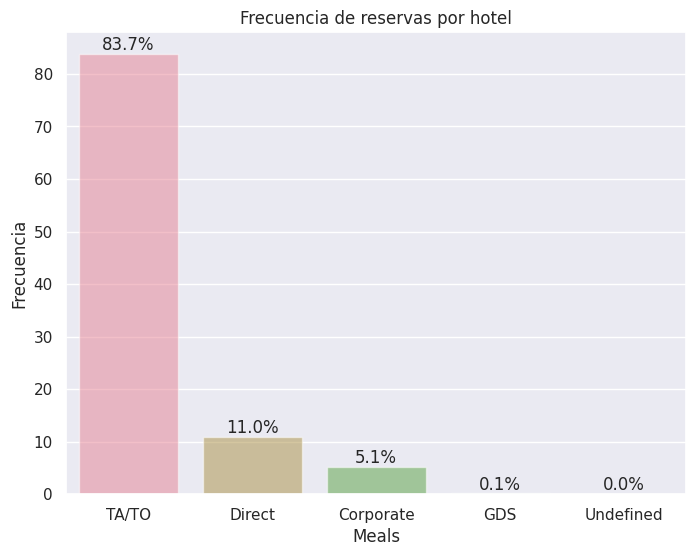

In [757]:
showBarPlot('distribution_channel', "Frecuencia de canales de distribución", x_label= 'Meals', y_label="Frecuencia", showPercentage = True)

La mayoría de reservas se hicieron mediante el canal de distribución de TA/TO

#### --------------------------------------------------------------------------

#### `is_repeated_guest`
  - Descripción: Indica si el usuario ya hizo una reserva anteriormente
  - Tipo de dato: Cualitativa
  - Valores posibles: 0 y 1
  - Frecuencia: _ver en código_ 



- ###### Frecuencia


In [758]:
round(df_hotels_train['is_repeated_guest'].value_counts(normalize=True) * 100, 2)

0    97.2
1     2.8
Name: is_repeated_guest, dtype: float64

- ###### Distribución


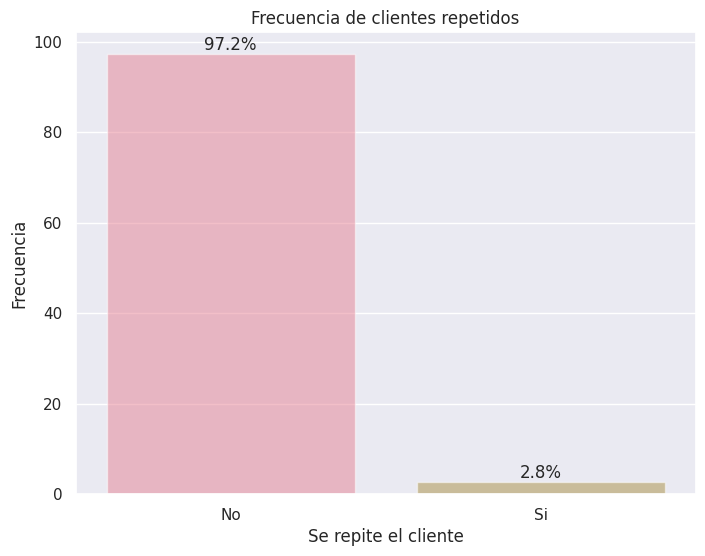

In [759]:
ds_hotels_reemplazo_valores = df_hotels_train.copy()

ds_hotels_reemplazo_valores.loc[ds_hotels_reemplazo_valores.loc[:,"is_repeated_guest"]==1,"is_repeated_guest"] = "Si"
ds_hotels_reemplazo_valores.loc[ds_hotels_reemplazo_valores.loc[:,"is_repeated_guest"]==0,"is_repeated_guest"] = "No"


showBarPlot('is_repeated_guest', "Frecuencia de clientes repetidos", x_label= 'Se repite el cliente', y_label="Frecuencia", showPercentage = True, df_hotels = ds_hotels_reemplazo_valores)

Para la mayoría de los clientes, es la primera vez que efectuan una reserva

#### `previous_cancellations`
  - Descripción: Indica cuantas cancelaciones hizo anteriormente
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [760]:
round(df_hotels_train['previous_cancellations'].describe(), 2)

count    61913.00
mean         0.11
std          0.99
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         26.00
Name: previous_cancellations, dtype: float64

  - ###### Distribución

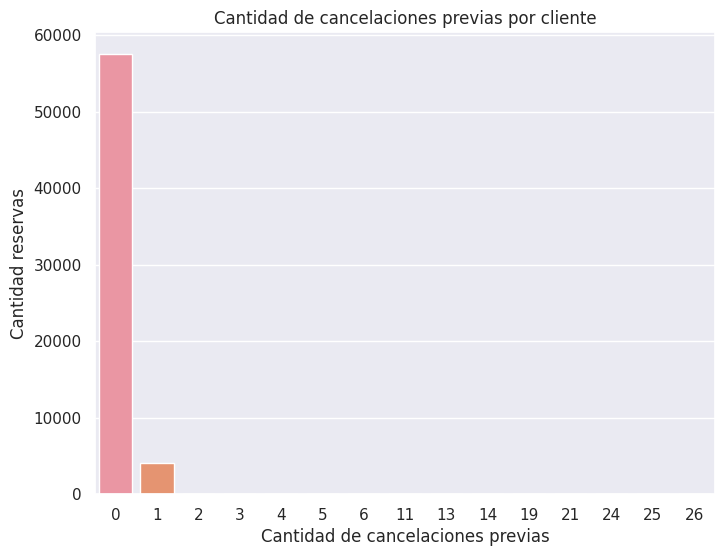

In [761]:
plot = sns.countplot(x='previous_cancellations', data=df_hotels_train).set(title = "Cantidad de cancelaciones previas por cliente", ylabel = "Cantidad reservas", xlabel = "Cantidad de cancelaciones previas")

La mayoría de clientes no registran haber cancelado anteriormente una reserva

#### --------------------------------------------------------------------------

#### `previous_bookings_not_canceled`
  - Descripción: Indica cuantas reservas completo
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [762]:
round(df_hotels_train['previous_bookings_not_canceled'].describe(), 2)

count    61913.00
mean         0.12
std          1.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         70.00
Name: previous_bookings_not_canceled, dtype: float64

  - ###### Distribución

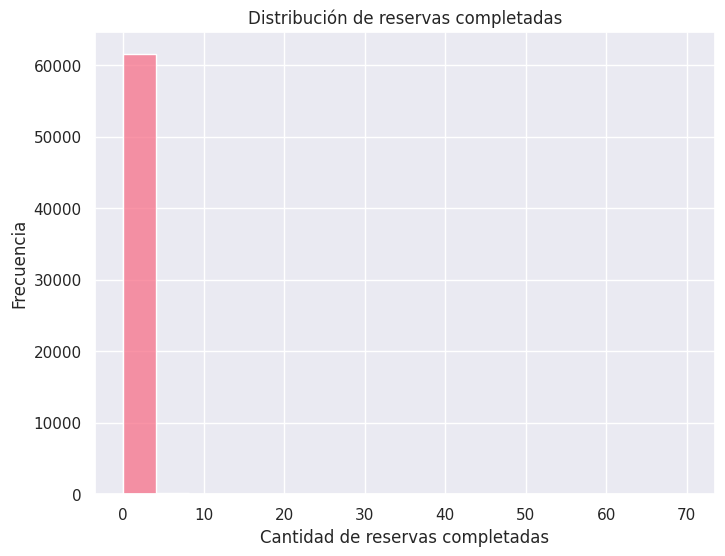

In [763]:
histplot = sns.histplot(data = df_hotels_train, x = "previous_bookings_not_canceled").set(title = "Distribución de reservas completadas", ylabel = "Frecuencia", xlabel = "Cantidad de reservas completadas")

La mayoría de los clientes no cancelaron sus reservas

#### --------------------------------------------------------------------------

#### `reserved_room_type`
  - Descripción: Tipo de habitacion reservada
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [764]:
#Valores posibles
df_hotels_train['reserved_room_type'].unique()

array(['D', 'A', 'F', 'E', 'G', 'B', 'C', 'H', 'P', 'L'], dtype=object)

- ###### Frecuencia


In [765]:
round(df_hotels_train['reserved_room_type'].value_counts(normalize=True) * 100, 2)

A    72.90
D    15.48
E     5.25
F     2.34
G     1.76
B     0.94
C     0.78
H     0.54
P     0.01
L     0.00
Name: reserved_room_type, dtype: float64

- ###### Distribución


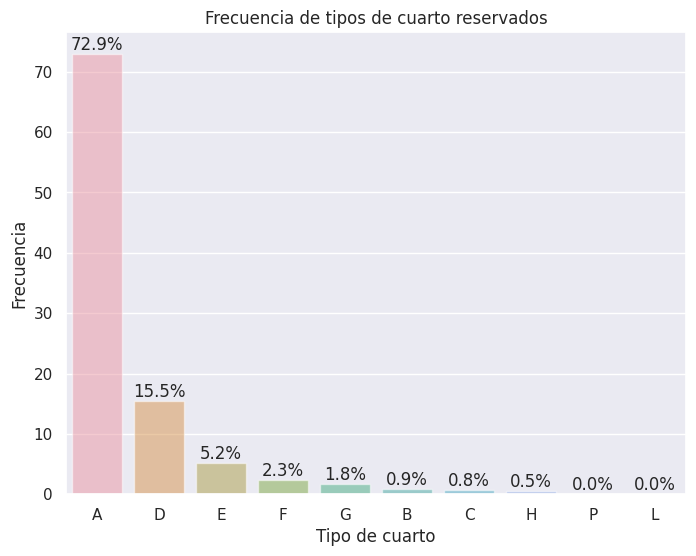

In [766]:
showBarPlot('reserved_room_type', "Frecuencia de tipos de cuarto reservados", x_label= 'Tipo de cuarto', y_label="Frecuencia", showPercentage = True)

El cuarto A es el cuarto más solicitado.

#### --------------------------------------------------------------------------

#### `assigned_room_type`
  - Descripción: Tipo de habitacion asignada
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [767]:
#Valores posibles
df_hotels_train['assigned_room_type'].unique()

array(['D', 'A', 'F', 'E', 'H', 'C', 'G', 'B', 'I', 'K', 'P', 'L'],
      dtype=object)

- ###### Frecuencia


In [768]:
round(df_hotels_train['assigned_room_type'].value_counts(normalize=True) * 100, 2)

A    64.62
D    19.69
E     6.10
F     2.94
G     2.06
C     1.82
B     1.71
H     0.62
I     0.23
K     0.19
P     0.01
L     0.00
Name: assigned_room_type, dtype: float64

- ###### Distribución


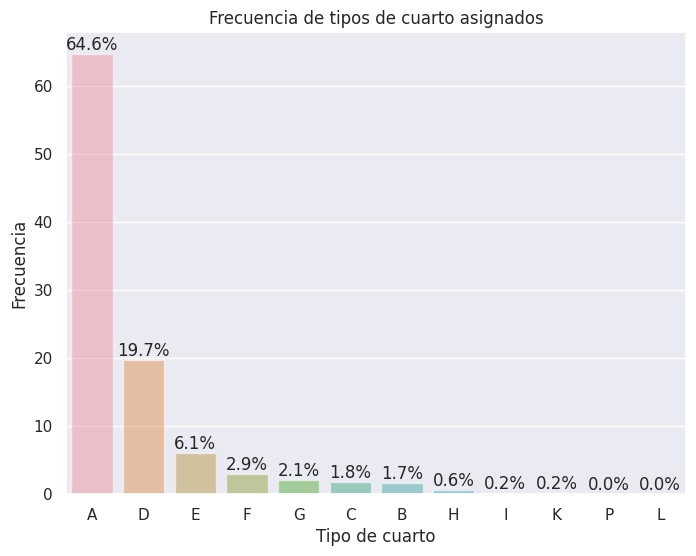

In [769]:
showBarPlot('assigned_room_type', "Frecuencia de tipos de habitaciones asignadas", x_label= 'Tipo de cuarto', y_label="Frecuencia", showPercentage = True)

El cuarto A es el más asignado. Podemos pensar que puede ser el cuarto standar y el más economico. Ya que los cuartos I, K, P y L son los menos asignados y solicitados

#### --------------------------------------------------------------------------

#### `booking_changes`
  - Descripción: Número de cambios hechos en la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [770]:
round(df_hotels_train['booking_changes'].describe(), 2)

count    61913.00
mean         0.20
std          0.61
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         17.00
Name: booking_changes, dtype: float64

  - ###### Distribución

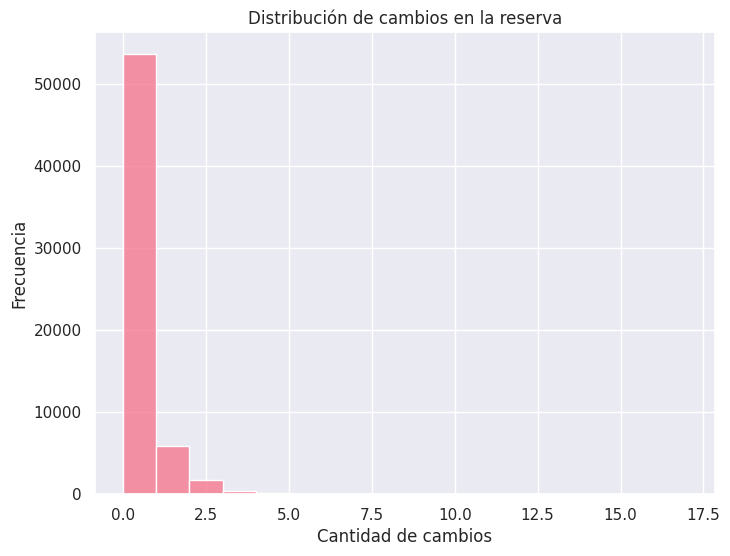

In [771]:
histplot = sns.histplot(data = df_hotels_train, x = "booking_changes").set(title = "Distribución de cambios en la reserva", ylabel = "Frecuencia", xlabel = "Cantidad de cambios")

La mayoría de clientes no efecutaron cambios en la reserva.

#### --------------------------------------------------------------------------

#### `deposit_type`
  - Descripción: Tipo de depósito que hizo el huésped para garantizar su reserva
  - Tipo de dato: Cualitativa
  - Valores posibles: _ver en codigo_ 
  - Frecuencia: _ver en codigo_ 


In [772]:
#Frecuencia
round(df_hotels_train['deposit_type'].value_counts(normalize=True) * 100, 2)

No Deposit    83.48
Non Refund    16.39
Refundable     0.13
Name: deposit_type, dtype: float64

In [773]:
#Valores posibles
df_hotels_train['deposit_type'].unique()

array(['No Deposit', 'Non Refund', 'Refundable'], dtype=object)

- ###### Distribución


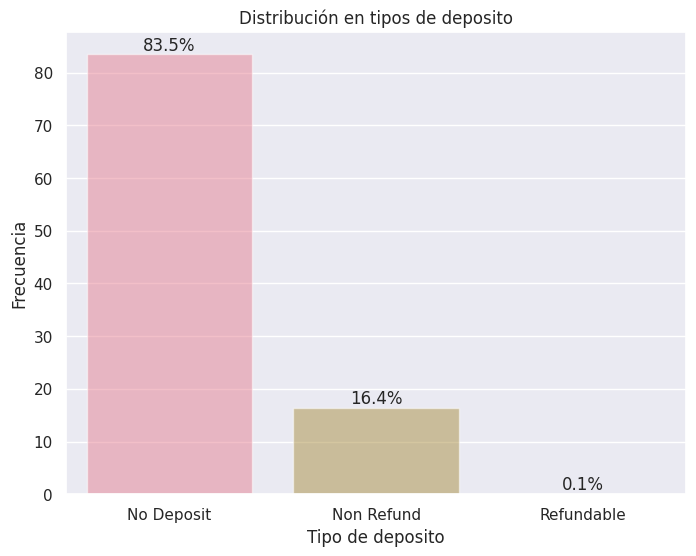

In [774]:
showBarPlot('deposit_type', "Distribución en tipos de deposito", x_label= 'Tipo de deposito', y_label="Frecuencia", showPercentage = True)

La mayoría de los clientes no efectuaron ningun deposito para garantizar la reserva.

#### --------------------------------------------------------------------------

#### `agent`
  - Descripción: Identificador del agente de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [775]:
#Frecuencia
round(df_hotels_train['agent'].value_counts(normalize=True) * 100, 2)

9.0      31.48
240.0    13.67
1.0       8.19
14.0      3.15
6.0       3.03
         ...  
420.0     0.00
352.0     0.00
450.0     0.00
283.0     0.00
25.0      0.00
Name: agent, Length: 296, dtype: float64

In [776]:
#Valores posibles
df_hotels_train['agent'].unique()

array([  9.,  nan, 154.,  20., 314., 240.,  58., 250.,  86., 229.,   1.,
        33.,   8.,   3., 236., 177.,  38.,  39., 170., 410.,  85.,  26.,
        96.,  14., 134.,  56., 234., 468., 254., 147.,  34., 138.,  40.,
        29., 315.,  37., 195., 326.,  35., 208.,  22.,  17., 296.,  28.,
         6.,  19.,  98.,  83., 298.,  27., 378., 484.,   7.,  16.,  21.,
       175., 171., 243.,  41.,  45.,  11., 157., 273.,  12., 387., 368.,
       434.,   5.,  36., 436., 405., 191., 257.,  95.,  15.,  31., 440.,
        50., 241.,   4.,  67.,  63., 168.,  44., 261., 281.,  94., 336.,
        30., 420., 104., 121., 464., 196., 142., 151., 242., 119., 339.,
       310., 531., 305.,   2.,  53.,  64., 248., 313., 364., 286., 459.,
       133., 132., 245., 143.,  52., 155., 251., 223., 156., 159., 185.,
       323.,  13., 330., 359., 527., 103.,  68., 174.,  82.,  42., 256.,
       483., 146.,  89., 252., 220.,  88., 303., 181., 152.,  24., 394.,
        75., 306., 183.,  69.,  10., 184., 149., 16

#### --------------------------------------------------------------------------

#### `company`
  - Descripción: Identificador de la compañia de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [777]:
#Frecuencia
round(df_hotels_train['company'].value_counts(normalize=True) * 100, 2)

40.0     12.37
223.0    11.55
67.0      5.36
45.0      3.74
153.0     3.36
         ...  
305.0     0.03
275.0     0.03
461.0     0.03
220.0     0.03
160.0     0.03
Name: company, Length: 276, dtype: float64

In [778]:
#Valores posibles
df_hotels_train['company'].unique()

array([ nan, 223., 512., 218., 233., 268., 385.,  88., 154.,  51., 281.,
       202.,  67., 405.,  45., 329.,  46., 197., 137., 366., 174.,  40.,
       144., 227.,  86., 159., 477., 308.,  43., 219.,  68., 407.,  81.,
       465., 343., 466., 353., 424., 485.,  38.,  94., 153.,  72.,  20.,
        47., 286., 195., 358., 277., 355.,  12., 498., 278.,  62., 393.,
       238., 242., 143., 135., 331., 400., 342., 110., 313.,  78., 348.,
       209., 452.,  99., 250., 118., 507., 397., 321., 113., 167.,   9.,
       204., 280.,  83., 203., 333., 365., 186., 324., 169., 496.,  31.,
       382., 270.,  84., 245., 274., 215., 418., 525., 290.,  39.,  14.,
       150., 251., 292.,  91., 230., 521., 320., 334., 408., 207., 122.,
       178.,  82., 388., 360., 148., 183.,  22., 435., 420., 523., 307.,
       319.,  49., 421., 380.,  54., 221., 282.,  48., 200., 126., 216.,
       338., 379., 356., 461., 543., 220., 371., 105., 311., 346., 269.,
       168., 372., 399., 120.,  37., 115., 291., 12

#### --------------------------------------------------------------------------

#### `days_in_waiting_list`
  - Descripción: Número de días que la reserva estuvo en lista de espera antes de ser confirmada al cliente
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

In [779]:
#Medidas
round(df_hotels_train['days_in_waiting_list'].describe(), 2)

count    61913.00
mean         2.64
std         18.62
min          0.00
25%          0.00
50%          0.00
75%          0.00
max        391.00
Name: days_in_waiting_list, dtype: float64

  - ###### Distribución

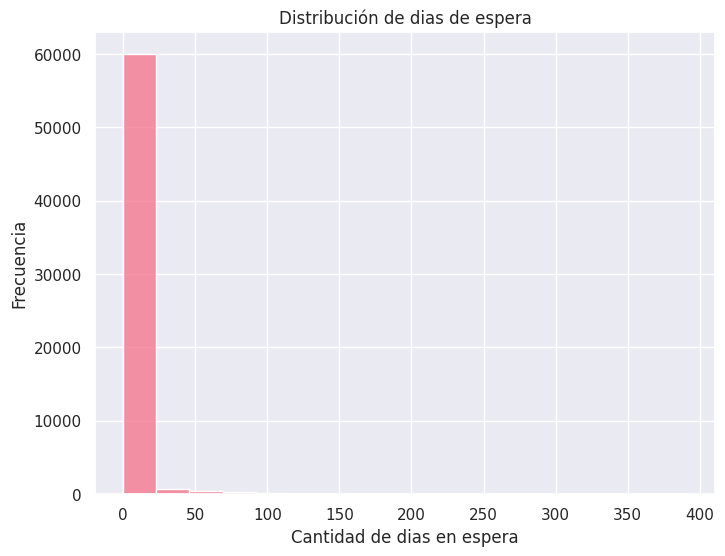

In [780]:
histplot = sns.histplot(data = df_hotels_train, x = "days_in_waiting_list").set(title = "Distribución de dias de espera", ylabel = "Frecuencia", xlabel = "Cantidad de dias en espera")

Podemos observar que, el tiempo promedio de espera, es de 1 a 25 días.

#### --------------------------------------------------------------------------

#### `customer_type`
  - Descripción: Tipo de usuario
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [781]:
#Frecuencia
round(df_hotels_train['customer_type'].value_counts(normalize=True) * 100, 2)

Transient          76.64
Transient-Party    19.65
Contract            3.28
Group               0.42
Name: customer_type, dtype: float64

In [782]:
#Valores posibles
df_hotels_train['customer_type'].unique()

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

- ###### Distribución


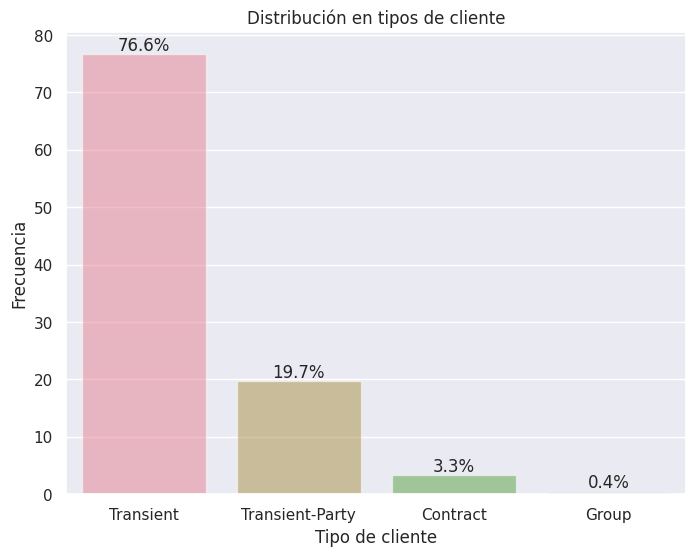

In [783]:
showBarPlot('customer_type', "Distribución de tipos de cliente", x_label= 'Tipo de cliente', y_label="Frecuencia", showPercentage = True)

La mayoría de los clientes hicieron una reserva individual y no forman parte de ningún grupo ni están asociados con ninguna otra reserva

#### --------------------------------------------------------------------------

#### `adr`
  - Descripción: Precio promedio por día
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver código_
  - Distribución: _ver código_


In [784]:
#Medidas
round(df_hotels_train['adr'].describe(), 2)

count    61913.00
mean       102.38
std         47.76
min         -6.38
25%         70.00
50%         95.00
75%        126.00
max        510.00
Name: adr, dtype: float64

  - ###### Distribución

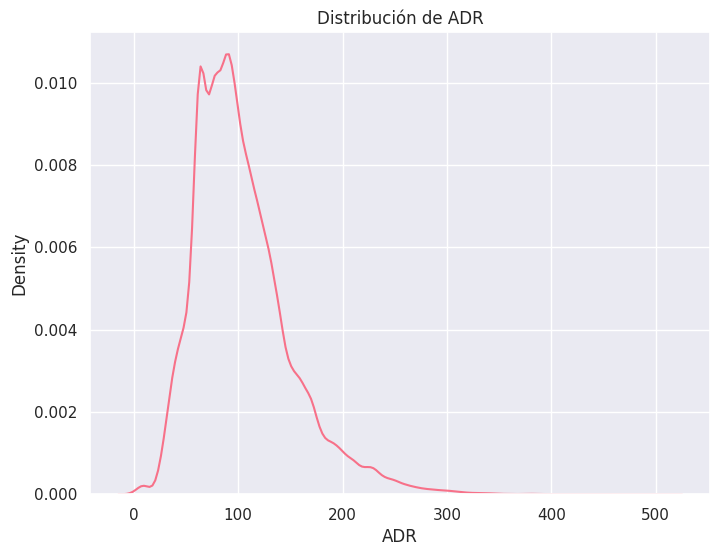

In [903]:
histplot = sns.kdeplot(data = df_hotels_train, x = "adr").set(title = "Distribución de ADR", xlabel = "ADR")

El promedio de precio por día es de 102 usd

#### --------------------------------------------------------------------------

#### `required_car_parking_spaces`
  - Descripción: Cantidad de estacionamientos pedidos por el usuario
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver código_
  - Distribución: _ver código_


In [786]:
#Medidas
round(df_hotels_train['required_car_parking_spaces'].describe(), 2)

count    61913.00
mean         0.05
std          0.22
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          8.00
Name: required_car_parking_spaces, dtype: float64

  - ###### Distribución

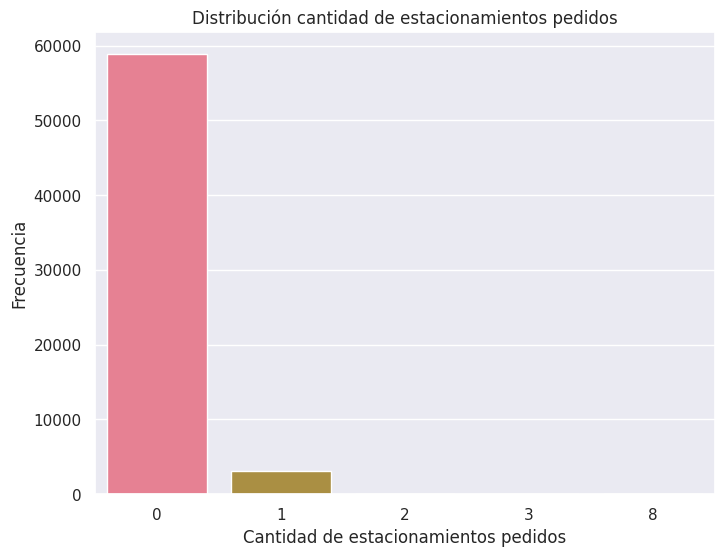

In [787]:
histplot = sns.countplot(data = df_hotels_train, x = "required_car_parking_spaces").set(title = "Distribución cantidad de estacionamientos pedidos", ylabel = "Frecuencia", xlabel = "Cantidad de estacionamientos pedidos")

La mayoría de los clientes no pidieron espacios para el estacionamiento

#### --------------------------------------------------------------------------

#### `total_of_special_requests`
  - Descripción: Cantidad de pedidos especiales del usario
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver código_
  - Distribución: _ver código_


In [788]:
#Medidas
round(df_hotels_train['total_of_special_requests'].describe(), 2)

count    61913.00
mean         0.52
std          0.78
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          5.00
Name: total_of_special_requests, dtype: float64

  - ###### Distribución

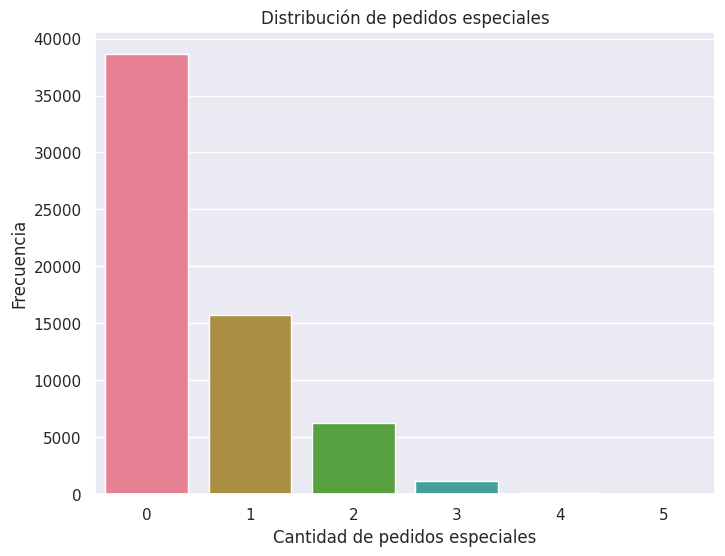

In [789]:
histplot = sns.countplot(data = df_hotels_train, x = "total_of_special_requests").set(title = "Distribución de pedidos especiales", ylabel = "Frecuencia", xlabel = "Cantidad de pedidos especiales")

La mayoría de los clientes no registraron pedidos especiales para su reserva

#### --------------------------------------------------------------------------

#### `reservation_status_date`
  - Descripción: Fecha de la última actualización  del estado
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver codigo_


In [790]:
#Medidas
df_hotels_train['reservation_status_date'].describe()

count          61913
unique           915
top       2015-10-21
freq            1013
Name: reservation_status_date, dtype: object

#### --------------------------------------------------------------------------

#### `id`
  - Descripción: Identificador de la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver codigo_


In [791]:
#Medidas
df_hotels_train['id'].describe()

count                                    61913
unique                                   61913
top       7aa4cc6b-b92c-4061-b21d-4f9e0cac4689
freq                                         1
Name: id, dtype: object

#### --------------------------------------------------------------------------

#### `is_canceled`
  - Descripción: Identificador de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [792]:
#Valores posibles
df_hotels_train['is_canceled'].unique()

array([1, 0])

- ###### Frecuencia


In [793]:
round(df_hotels_train['is_canceled'].value_counts(normalize=True) * 100, 2)

0    50.03
1    49.97
Name: is_canceled, dtype: float64

- ###### Distribución


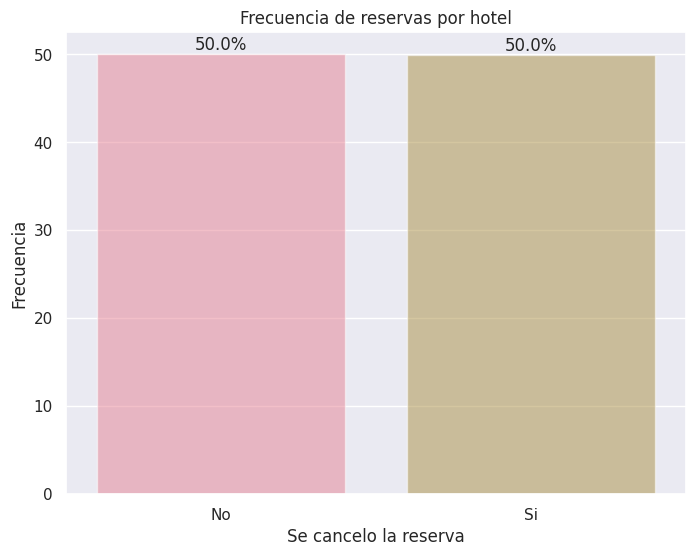

In [794]:
ds_hotels_reemplazo_valores = df_hotels_train.copy()

ds_hotels_reemplazo_valores.loc[ds_hotels_reemplazo_valores.loc[:,"is_canceled"]==1,"is_canceled"] = "Si"
ds_hotels_reemplazo_valores.loc[ds_hotels_reemplazo_valores.loc[:,"is_canceled"]==0,"is_canceled"] = "No"


showBarPlot('is_canceled', "Frecuencia de cancelaciones", x_label= 'Se cancelo la reserva', y_label="Frecuencia", showPercentage = True, df_hotels = ds_hotels_reemplazo_valores)

## Variables irrelevantes

Analizando el dataset, podemos encontrar las siguientes columnas que no aportan una información relevante para el análisis de la variable **target**.

Columnas:
- `agent`: Es un identificador, no provee información importante
- `company`: Es un identificador, no provee información importante
- `reservation_status_date`: Como está relacionada a una variable que no se encuentra, tampoco se tendrá en cuenta.

La columna `id` tambien es un identificador, pero en este caso no lo vamos a eliminar, ya que es necesario para la competencia _Kaggle_.

Al hacer dicho análisis, procedemos a eliminar dichas columnas del dataset de training y test

## Correlaciones

### Variables cuantitativas

A continuación veremos un gráfico que representara la correlación entre las variables

[Text(0.5, 1.0, 'Correlaciones entre variables cuantitativas')]

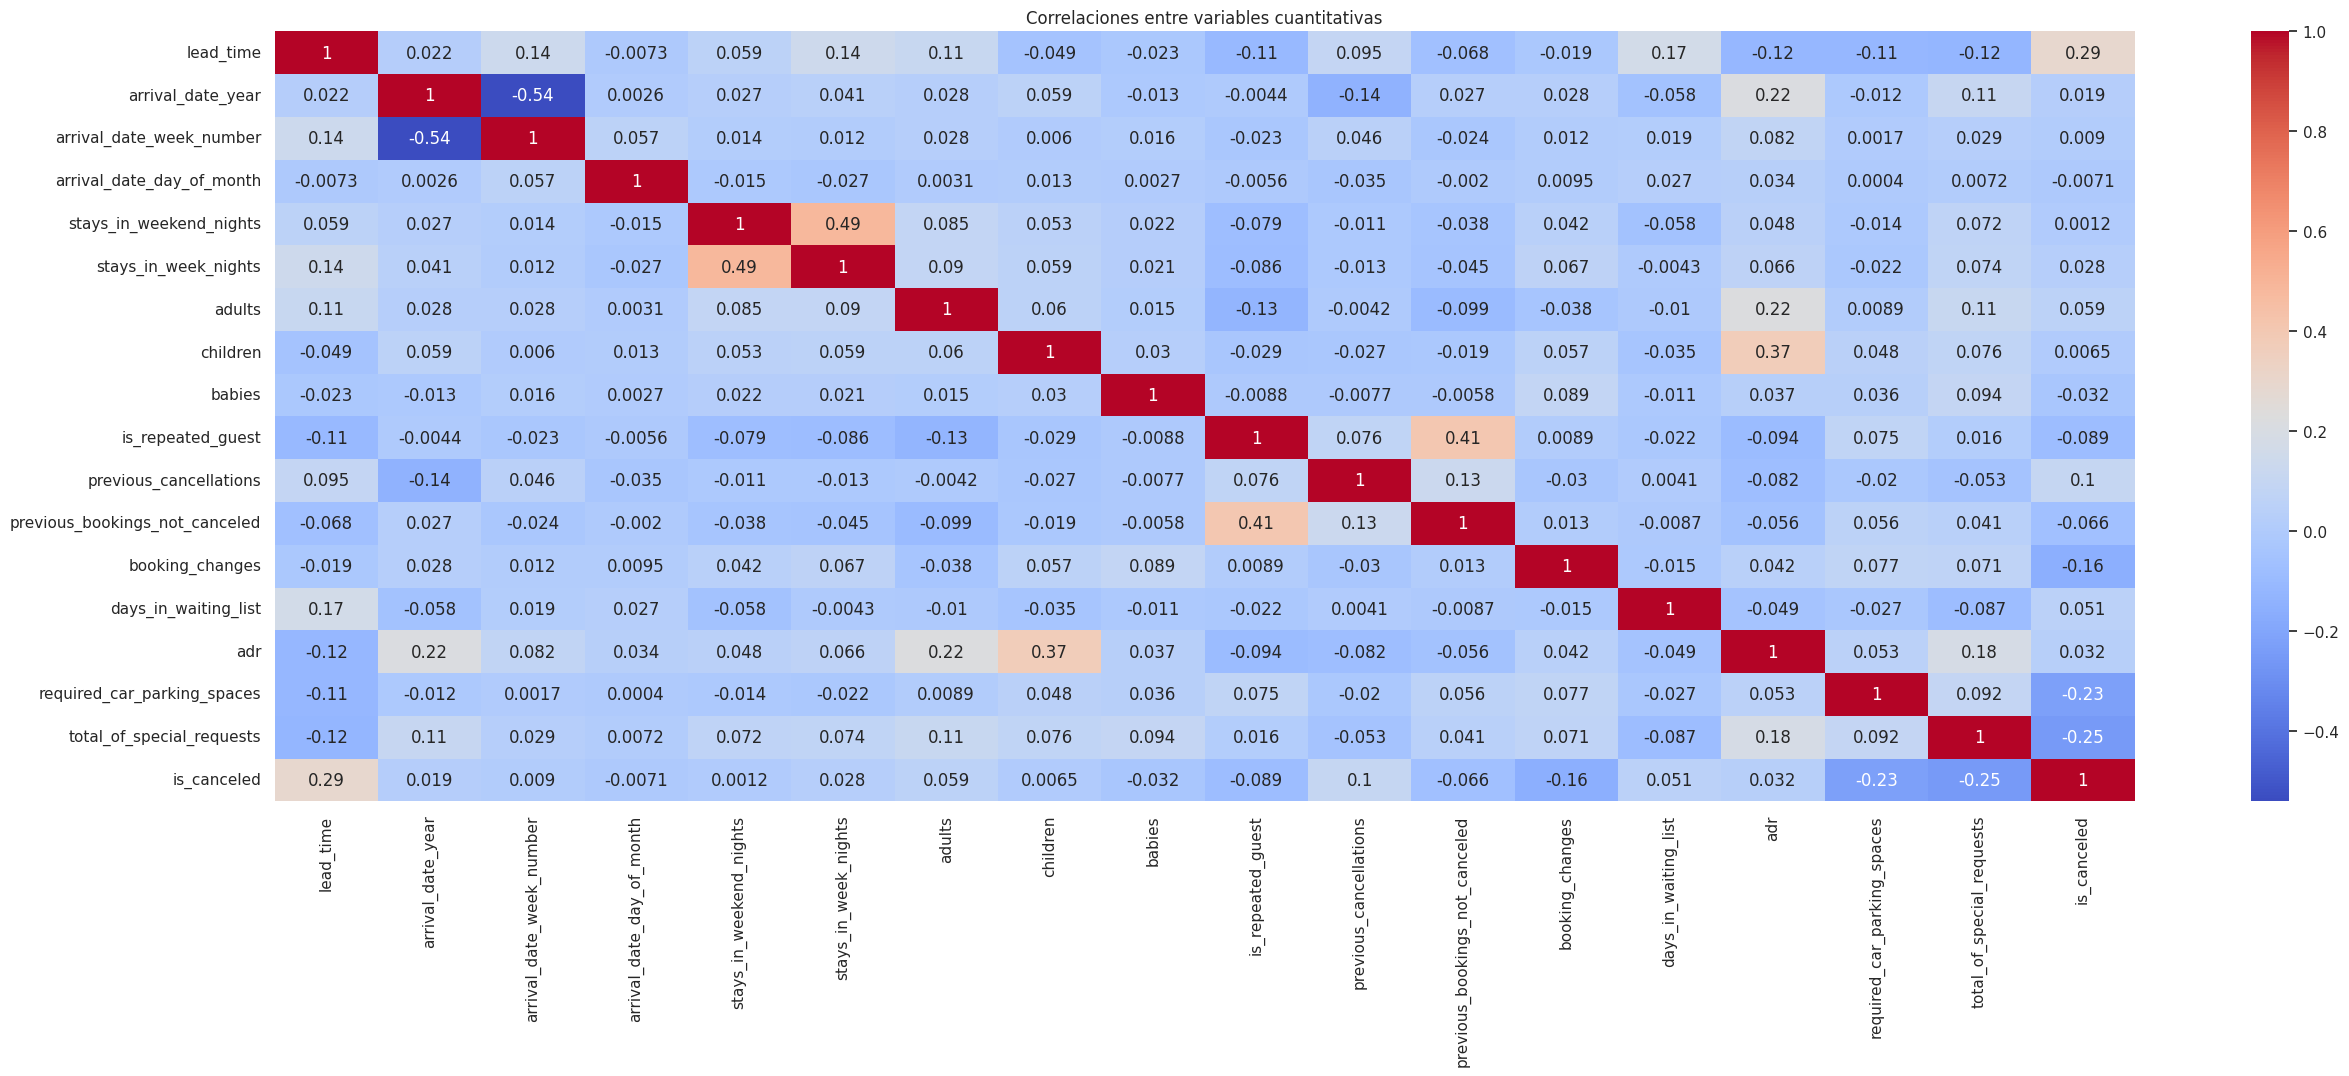

In [904]:
plt.figure(figsize = (30,10))
sns.heatmap(df_hotels_train.corr(), annot=True, cmap='coolwarm').set(title = "Correlaciones entre variables cuantitativas")

Vamos a analizar las correlaciónes entre las variables sin tener encuenta nuestro **target**.
- `lead_time`: 
  - Correlación negativa moderada leve con `is_repeated_guest` (-0.11)
  - Correlación negativa moderada leve con `required_car_parking_spaces` (-0.11)
  - Correlación negativa moderada leve con `total_of_special_requests` (-0.12)
- `arrival_date_year`: 
  - correlación negativa significativa con `arrival_date_week_number` (-0.54)
  - Correlación positiva leve con `adr` (0.22)
  - Correlación negativa moderada leve con `previous_cancelations` (-0.14)
- `arrival_date_week_number`:
  - Correlación positiva leve con `lead_time`



  Continuar análisis.

### Variables cualitativas

Podemos observar que, las variables cualitativas, no se encuentran representadas en el anterior _heapmap_. Esto es porque la matriz de correlación que calcula pandas, solo es para variables cuantitativas. Por lo tanto, para el análisis de las correllaciones de las variables **cualitativas**, utilizaremos la medida de _V de cramer_.

> La V de Cramer es una medida de asociación estadística utilizada para analizar la relación entre dos variables categóricas. Es una medida de la fuerza de la relación entre las dos variables, que varía entre 0 (no hay asociación) y 1 (asociación perfecta). Se calcula a partir de la tabla de contingencia de las dos variables, que muestra la frecuencia conjunta de las distintas combinaciones de categorías de ambas variables. 

[Informacion sobre V de cramer](https://en.m.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

Para poder lograr un análisis más preciso, vamos a crear una nueva columna que represente el mes de llegada.

In [796]:
df_hotels_train['arrival_date_month'] = df_hotels_train.apply(lambda column: weekNumberToMonth(column['arrival_date_year'], column['arrival_date_week_number']), axis = 1)
df_hotels_test['arrival_date_month'] = df_hotels_test.apply(lambda column: weekNumberToMonth(column['arrival_date_year'], column['arrival_date_week_number']), axis = 1)

Creamos un heapmap con una matriz de correlación utilizando V de cramer.

Para poder obtener una mayor precision en el análisis de las correlaciones de las variables cualitativas, transformaremos la columna `is_canceled` a una variable cualitativa con valores posibles "Si" y "No".


[Text(0.5, 1.0, 'Correlaciones entre variales cualitativas')]

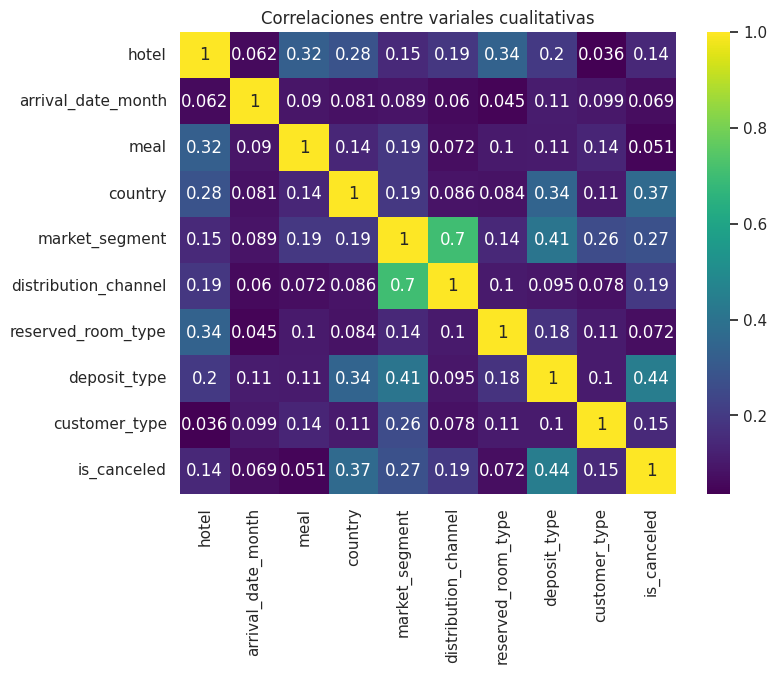

In [797]:
variables_cualitativas = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type', 'is_canceled']

df_hotels_train_copy = df_hotels_train.copy()
df_hotels_train_copy.loc[df_hotels_train_copy.loc[:,"is_canceled"]==1,"is_canceled"] = "Si"
df_hotels_train_copy.loc[df_hotels_train_copy.loc[:,"is_canceled"]==0,"is_canceled"] = "No"

corr_matrix = np.zeros((len(variables_cualitativas), len(variables_cualitativas)))

for i, var1 in enumerate(variables_cualitativas):
    for j, var2 in enumerate(variables_cualitativas):
        corr_matrix[i, j] = cramers_v(df_hotels_train_copy[var1], df_hotels_train_copy[var2])

sns.heatmap(corr_matrix, annot=True, xticklabels=variables_cualitativas, yticklabels=variables_cualitativas, cmap= "viridis").set(title="Correlaciones entre variales cualitativas")

## Visualización adicional de datos

### Análisis de variables con la variables **target**

#### Cantidad de estacionamientos pedidos en reservas canceladas

[Text(0.5, 1.0, 'Cantidad de estacionamientos pedidos en según la cancelación'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Cantidad de estacionamientos pedidos')]

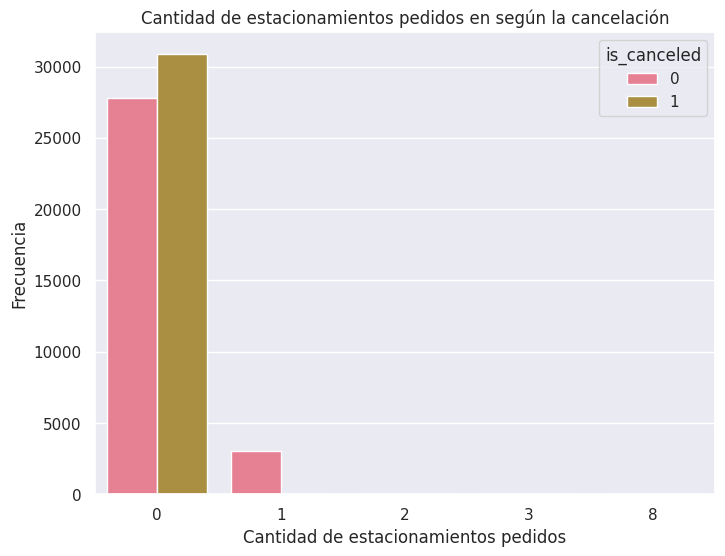

In [906]:
sns.countplot(df_hotels_train, x = 'required_car_parking_spaces', hue="is_canceled").set(title = "Cantidad de estacionamientos pedidos en según la cancelación",  ylabel = "Frecuencia", xlabel = "Cantidad de estacionamientos pedidos")

Podemos concluir en que el gráfico no proporciona información valiosa. 

#### Cantidad de pedidos especiales en reservas canceladas

[Text(0.5, 1.0, 'Cantidad de pedidos especiales en según la cancelación'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Cantidad de pedidos especiales')]

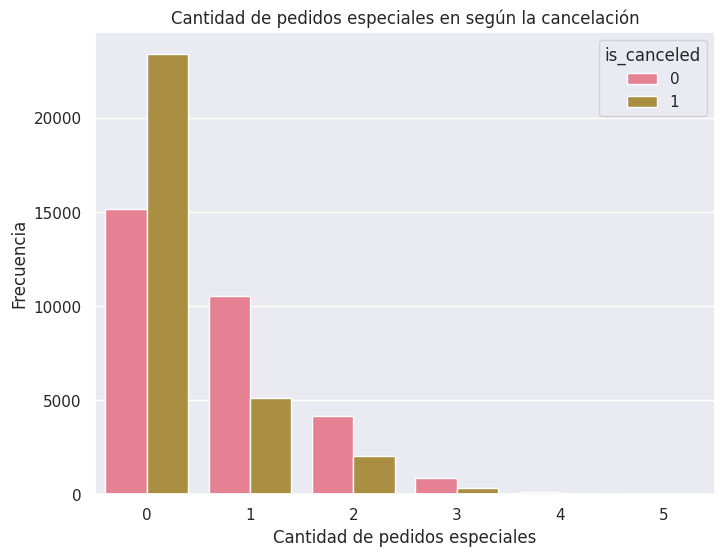

In [907]:
sns.countplot(df_hotels_train, x = 'total_of_special_requests', hue="is_canceled").set(title = "Cantidad de pedidos especiales en según la cancelación", ylabel = "Frecuencia", xlabel = "Cantidad de pedidos especiales")

A medida de que el cliente tenga pedidos especiales, la cantidad de cancelaciones disminuye. 

Podemos concluir en que el gráfico no proporciona información valiosa. 

#### Tipo de deposito con cancelacion

Representamos en un gráfico de torta el porcentaje del total de cancelaciones por hotel.

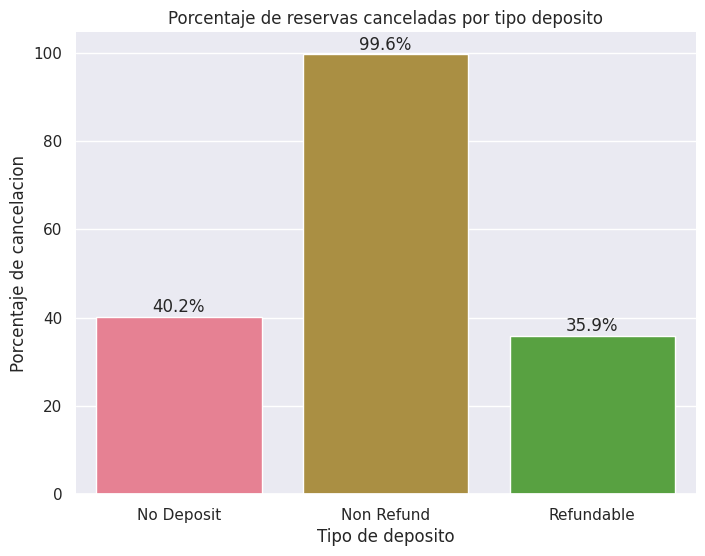

In [800]:
hotel_cancel_perc = df_hotels_train.groupby(['deposit_type'])['is_canceled'].mean() * 100


ax = sns.barplot(x=hotel_cancel_perc.index, y=hotel_cancel_perc.values)
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,6)})
sns.set_palette("husl")
sns.despine(left=True)


for i, v in enumerate(hotel_cancel_perc.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center')


plt.title('Porcentaje de reservas canceladas por tipo deposito')
plt.xlabel('Tipo de deposito')
plt.ylabel('Porcentaje de cancelacion')

plt.show()

Podemos observar que el tipo de deposito que se encuentra en el 96% de las reservas canceladas, es "Non Refund"

#### hotel con cancelacion

Representamos en un gráfico de torta el porcentaje del total de cancelaciones por hotel.

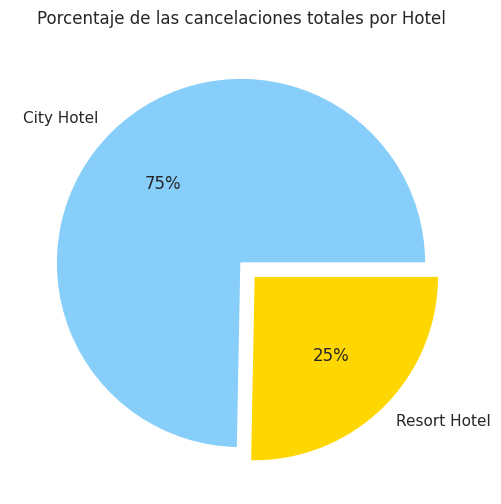

In [801]:
df_filtrado = df_hotels_train[df_hotels_train['is_canceled'] == 1]
data = df_filtrado['hotel'].value_counts().tolist()
labels = df_hotels_train['hotel'].value_counts().index.tolist()
colors = ['lightskyblue','gold']
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', explode=(0, 0.1))
plt.title(label = "Porcentaje de las cancelaciones totales por Hotel")
plt.show()

En el análisis de distribución de la variable `hotel` pudimos observar que el hotel _City_ es el más frecuente. Con éste gráfico observamos que, no solamente es el hotel más solicitado, sino que tambien es el que tiene una tasa de cancelación mayor al del hotel _Resort_.

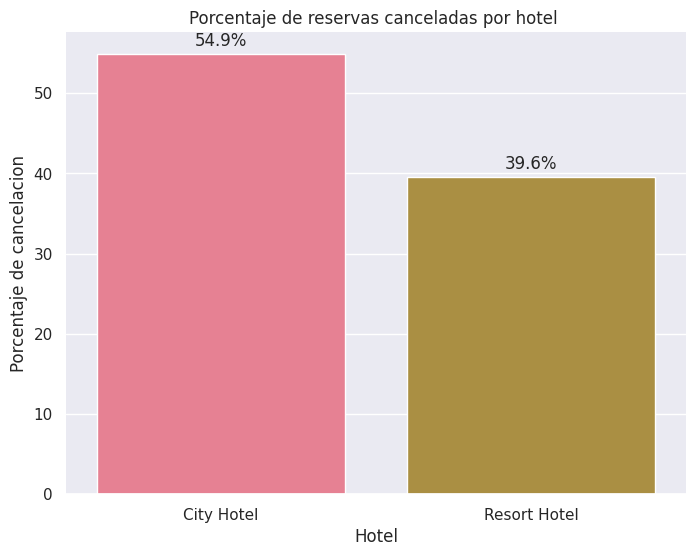

In [802]:
hotel_cancel_perc = df_hotels_train.groupby(['hotel'])['is_canceled'].mean() * 100


ax = sns.barplot(x=hotel_cancel_perc.index, y=hotel_cancel_perc.values)
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,6)})
sns.set_palette("husl")
sns.despine(left=True)


for i, v in enumerate(hotel_cancel_perc.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center')


plt.title('Porcentaje de reservas canceladas por hotel ')
plt.xlabel('Tipo de hotel')
plt.ylabel('Porcentaje de cancelacion')

plt.show()

Sabemos que el hotel _City_ posee 42101 reservas, pero con éste gráfico, podemos observar que de 42101 reservas, el 54,9% son canceladas, lo cual equivale a unas 23114 reservas son canceladas. 

En cambio con el hotel _Resort_, que posee 19812 reservas, solamente son canceladas 7846 reservas.

#### lead_time con is_canceled

<Axes: xlabel='is_canceled', ylabel='lead_time'>

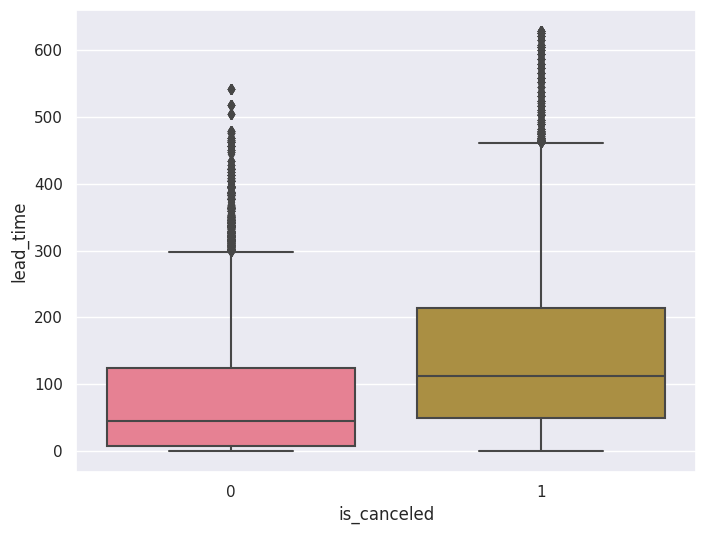

In [803]:
sns.boxplot(df_hotels_train, y = 'lead_time', x = 'is_canceled').set(title = "Distribución de lead_time según la cancelación de reservas", xlabel="Se canceló")

[Text(0, 0.5, '')]

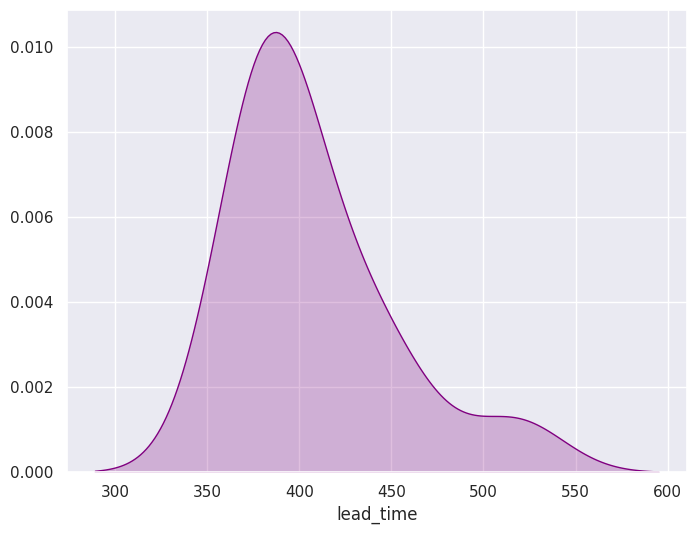

In [804]:
cancelas_por_lead_time = df_hotels_train.groupby(['lead_time'])['is_canceled'].agg('sum').reset_index()
ax = sns.kdeplot(cancelas_por_lead_time[cancelas_por_lead_time['is_canceled'] == 1]['lead_time'], color='purple', fill=True)
ax.set(ylabel=None, title = "Densidad de probabilidad del tiempo de espera en función del estado de la reserva.
")

<Axes: xlabel='is_canceled', ylabel='lead_time'>

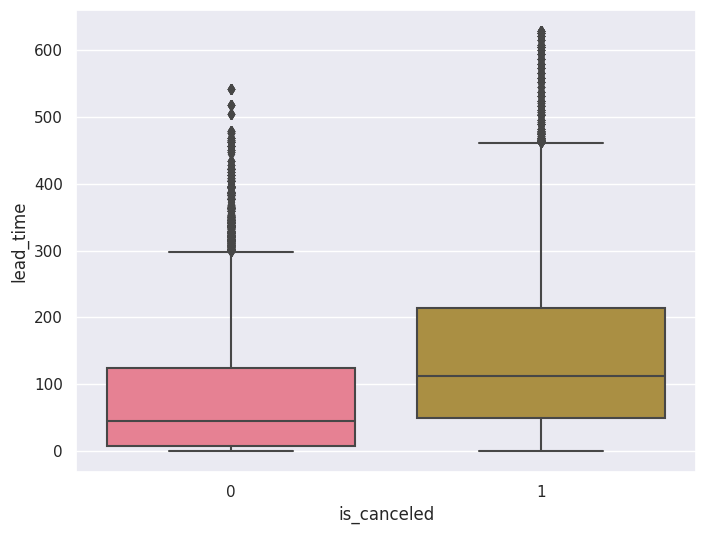

In [805]:
sns.boxplot(df_hotels_train, y = 'lead_time', x = 'is_canceled')

[Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Densidad de probabilidad del tiempo de espera en función del estado de la reserva')]

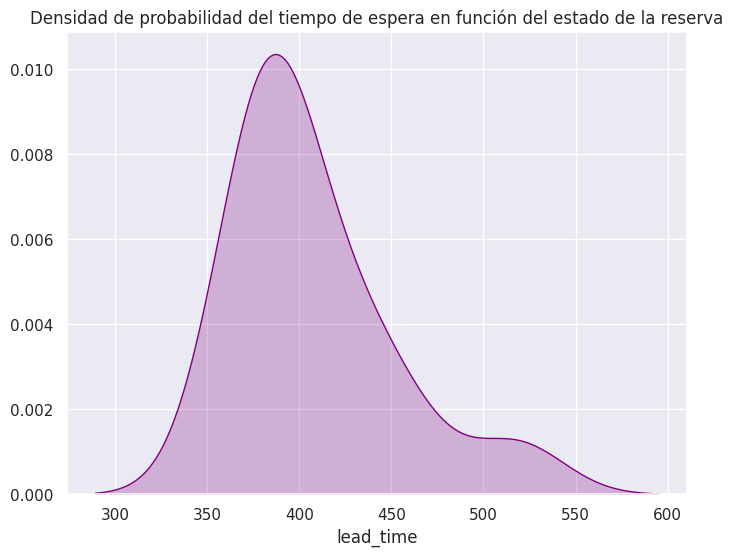

In [908]:
cancelas_por_lead_time = df_hotels_train.groupby(['lead_time'])['is_canceled'].agg('sum').reset_index()
ax = sns.kdeplot(cancelas_por_lead_time[cancelas_por_lead_time['is_canceled'] == 1]['lead_time'], color='purple', fill=True)
ax.set(ylabel=None, title= "Densidad de probabilidad del tiempo de espera en función del estado de la reserva")

### Análisis entre varables (sin **target**)

#### Análisis del tipo de habitacion reservada con el precio promedio por dia 

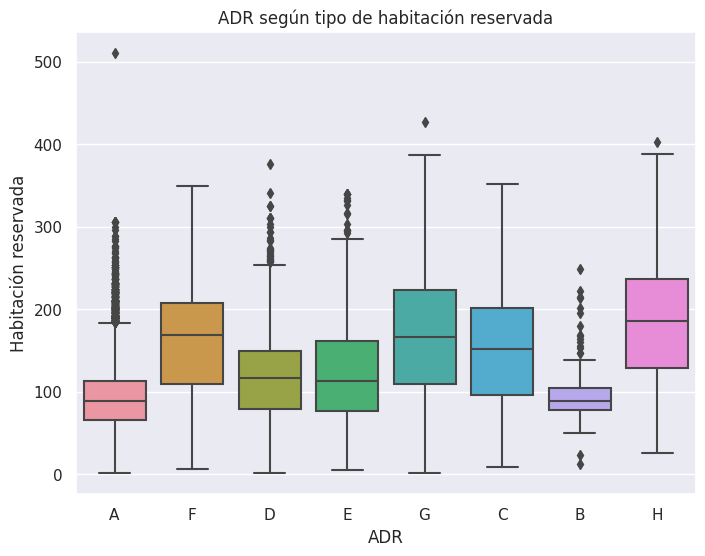

In [909]:
plot = sns.boxplot(x='reserved_room_type',y = 'adr', data = df_hotels_train[df_hotels_train['is_canceled'] == 0]).set(title = "ADR según tipo de habitación reservada", xlabel="ADR", ylabel="Habitación reservada")

#### Análisis de evolucion del adr por mes de cada hotel

In [808]:
df_hotel_resort = df_hotels_train[(df_hotels_train['hotel'] == "Resort Hotel" ) ]
df_hotel_city = df_hotels_train[(df_hotels_train['hotel'] == "City Hotel") ]

resort_month = df_hotel_resort.groupby(['arrival_date_month'])['adr'].mean().reset_index()
city_month = df_hotel_city.groupby(['arrival_date_month'])['adr'].mean().reset_index()

df_hotel_adr_merge = resort_month.merge(city_month, on='arrival_date_month')

In [809]:
df_hotel_adr_merge.rename(columns= {'adr_x': 'adr_city', 'adr_y': 'adr_resort'}, inplace=True)
sortByMonth(df_hotel_adr_merge)
df_hotel_adr_merge

,arrival_date_month,adr_city,adr_resort
4,Jan,65.082734,88.457337
3,Feb,55.984911,86.382924
7,Mar,58.990385,91.796058
0,Apr,77.532658,109.861622
8,May,81.553933,120.555634
6,Jun,111.497968,118.093763
5,Jul,158.110655,112.702593
1,Aug,186.535642,110.822633
11,Sep,99.341396,107.448000
10,Oct,66.154798,103.199830


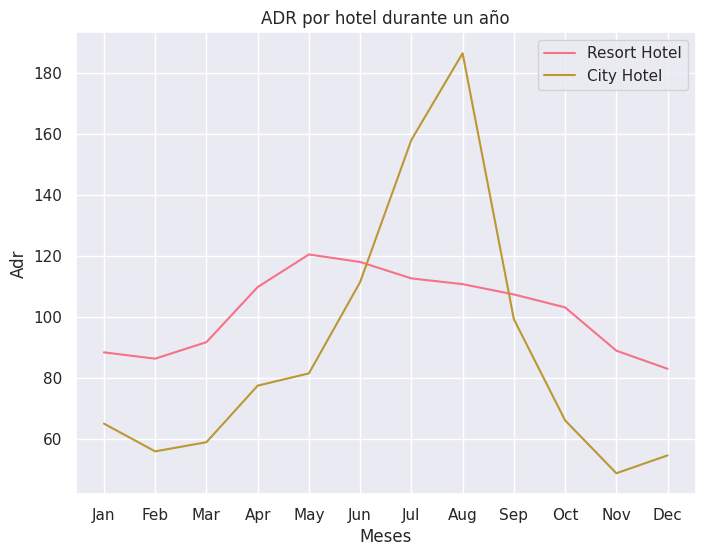

In [810]:
sns.lineplot(df_hotel_adr_merge, x="arrival_date_month", y="adr_resort", label="Resort Hotel")
sns.lineplot(df_hotel_adr_merge, x="arrival_date_month", y="adr_city", label="City Hotel")
plt.legend()
plt.xlabel("Meses")
plt.ylabel("Adr")
plt.title("ADR por hotel durante un año")
plt.show()

In [912]:
fig =px.line(data_frame = df_hotel_adr_merge, x = 'arrival_date_month', y = ['adr_resort', 'adr_city'], template = 'plotly_dark', title="ADR por hotel durante un año", labels={
                     "value": "Adr",
                     "arrival_date_month": "Meses",                  
                 })

fig.update_layout(width=800, height=600)

Anteriormente pudimos observar que, el tiempo en donde se hacen la mayoría de las reservas, es entre Julio y Agosto. El hotel _City_ en temporada alta de demanda, recurre a aumentar los precios de las reservas, lo cual puede explicar el porqué tiene una tasa de cancelación alta.
Por otro lado, el hotel _Resort_, no aumenta el precio en temporada alta, por lo tanto puede explicar por qué posee menos cancelaciones que el hotel _City_.

#### Análisis de cancelaciones del segmento de comercio con el tipo de deposito

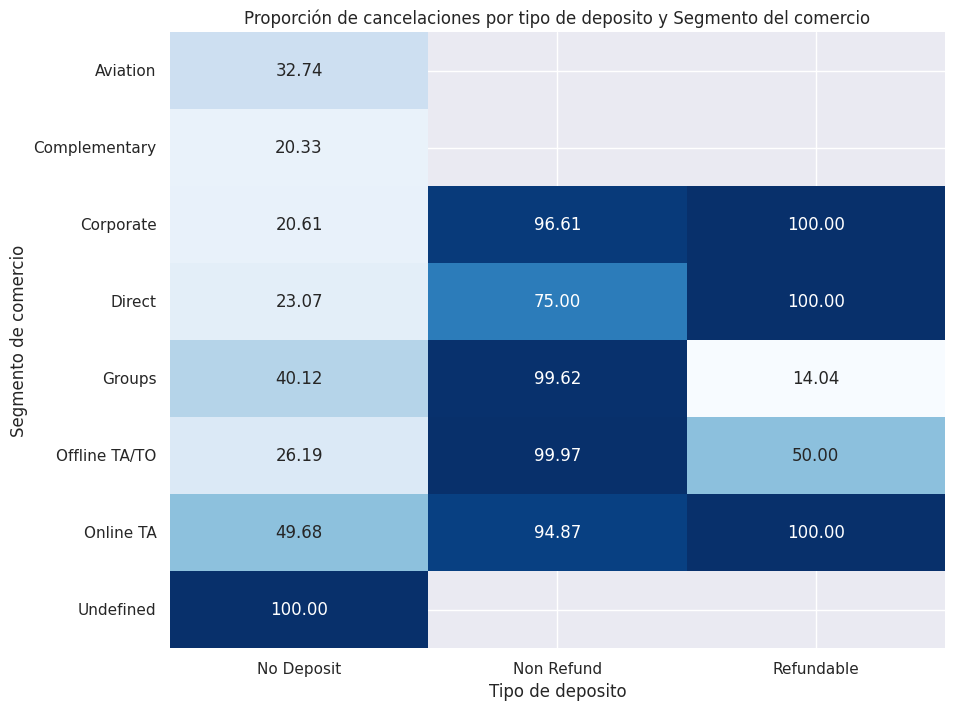

In [812]:
grouped = ((df_hotels_train.groupby(['deposit_type', 'market_segment'])['is_canceled']).mean() * 100 ).reset_index() 
pivot = grouped.pivot('market_segment', 'deposit_type', 'is_canceled')
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(pivot, annot=True,  fmt='.2f', cbar = False, cmap='Blues')
ax.set_xlabel('Tipo de deposito')
ax.set_ylabel('Segmento de comercio')
ax.set_title('Proporción de cancelaciones por tipo de deposito y Segmento del comercio')
plt.show()

Podemos observar que las reservas que se les asigno un tipo de deposito "Non Refund" y "Refundable" tienen una mayor tasa de cancelación en comparacion al "No deposit", sin embargo estas reservas represetan una menor porcentaje de la población total.

#### Análisis del tipo de cuarto asignado con el adr

In [911]:
fig = px.box(data_frame = df_hotels_train, x = 'reserved_room_type', y = 'adr', color = 'hotel', template = 'plotly_dark', title="ADR por hotel y por tipo de habitación")
fig.update_layout(width=800, height=600)


## Imputacion de datos

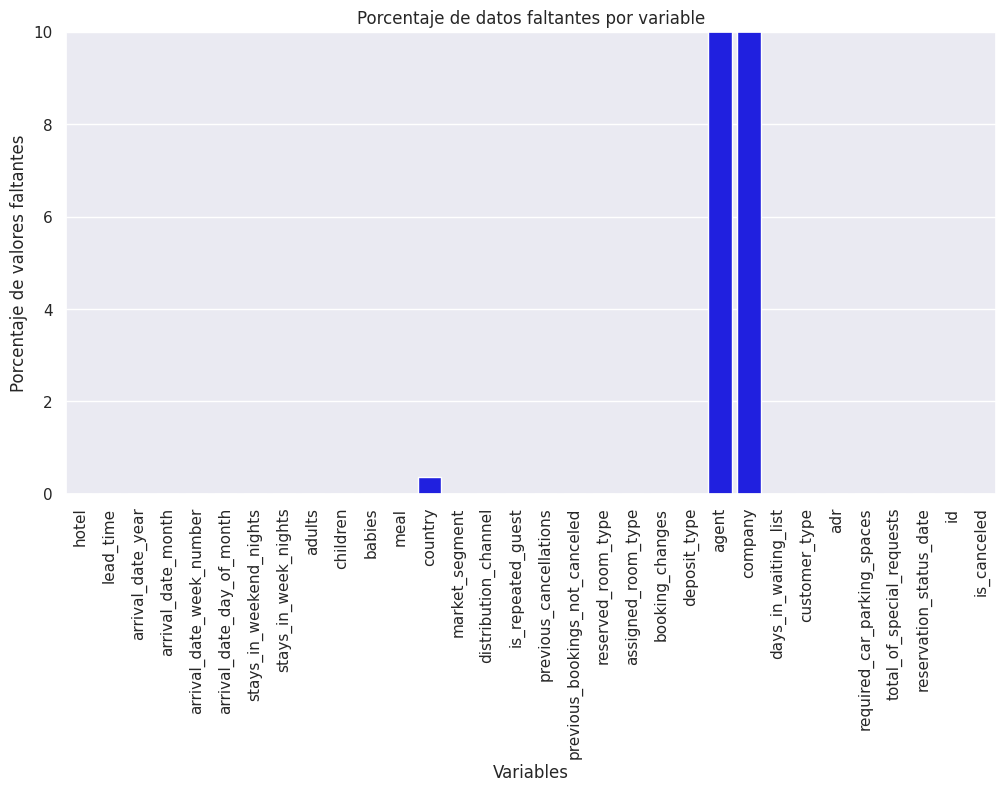

In [815]:
missing_data = df_hotels_train.isnull().mean() * 100

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_data.index, y=missing_data.values, color='blue').set(ylim=(0, 10))

# Añadir detalles al gráfico
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Porcentaje de valores faltantes')
plt.title('Porcentaje de datos faltantes por variable')
plt.show()

In [816]:
columnas_con_null = df_hotels_train.columns[df_hotels_train.isnull().any()]
print(df_hotels_train[columnas_con_null].isnull().sum())

children        4
country       221
agent        7890
company     58761
dtype: int64


### Análisis e imputaciones de reservas segun datos de la familia

In [817]:
  cantidad_reservas_sin_adultos = df_hotels_train[df_hotels_train['adults'] == 0].shape[0]
  print(f'Cantidad de reservas sin adultos: {cantidad_reservas_sin_adultos}')

  cantidad_reservas_sin_adultos_con_hijos = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] != 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y con hijos: {cantidad_reservas_sin_adultos_con_hijos}')

  cantidad_reservas_sin_adultos_sin_hijos = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] == 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y sin hijos: {cantidad_reservas_sin_adultos_sin_hijos}')

  cantidad_reservas_sin_adultos_con_hijos_con_bebes = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] != 0) & (df_hotels_train['babies'] != 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y sin hijos y con bebes: {cantidad_reservas_sin_adultos_con_hijos_con_bebes}')
  cantidad_reservas_sin_adultos_sin_hijos_sin_bebes = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] == 0)& (df_hotels_train['babies'] == 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y sin hijos y sin bebes: {cantidad_reservas_sin_adultos_sin_hijos_sin_bebes}')

Cantidad de reservas sin adultos: 197
Cantidad de reservas sin adultos y con hijos: 121
Cantidad de reservas sin adultos y sin hijos: 76
Cantidad de reservas sin adultos y sin hijos y con bebes: 1
Cantidad de reservas sin adultos y sin hijos y sin bebes: 76


Hay 197 reservas en las cuales no hay adultos registrados. Son casos que carecen de sentido y representar una poblacion bastante reducida en comparación a la total (más de 60K de registros). Puede haber una excepción de que un adulto con hijos haya hecho una reserva para él y otra para los hijos, por lo tanto habria una reserva con un adulto y sin hijos y otra con hijos pero sin adultos. Es un caso muy particular, por lo tanto para evitar tener datos basura, tomamos la decision de borrar dichos registros.

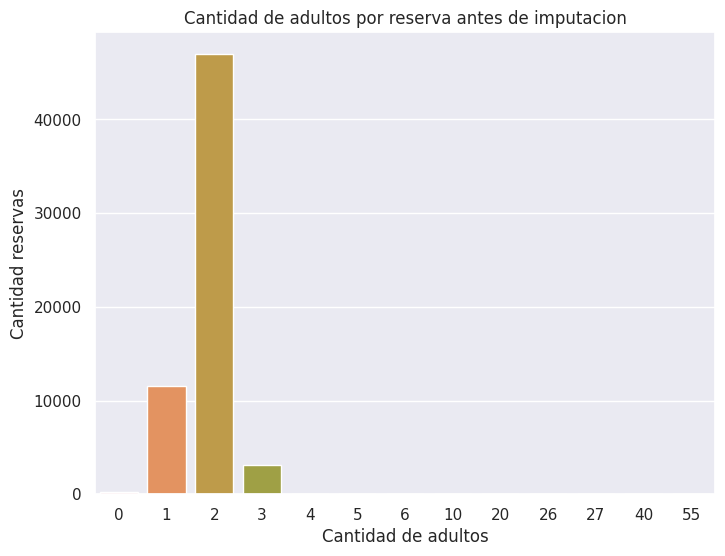

In [818]:
plot = sns.countplot(x='adults', data=df_hotels_train).set(title = "Cantidad de adultos por reserva antes de imputacion", ylabel = "Cantidad reservas", xlabel = "Cantidad de adultos")

In [819]:
df_hotels_train.drop(df_hotels_train[df_hotels_train['adults'] == 0].index, axis = 0, inplace=True)
df_hotels_test.drop(df_hotels_test[df_hotels_test['adults'] == 0].index, axis = 0, inplace=True)

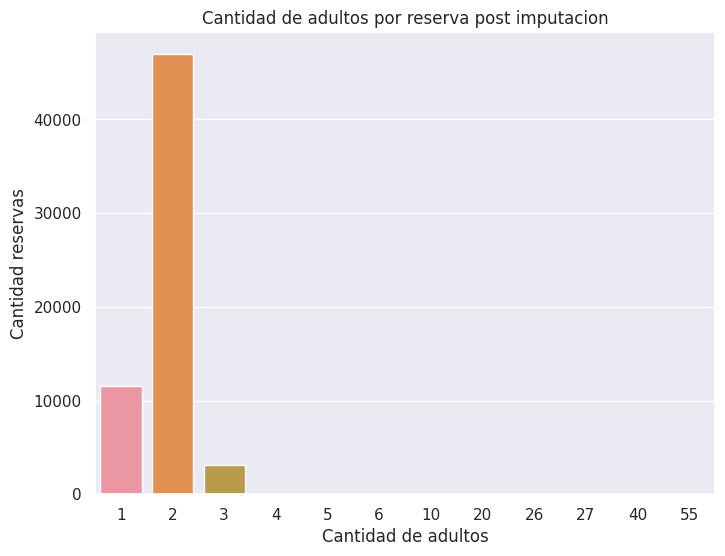

In [820]:
plot = sns.countplot(x='adults', data=df_hotels_train).set(title = "Cantidad de adultos por reserva post imputacion", ylabel = "Cantidad reservas", xlabel = "Cantidad de adultos")

In [821]:
  cantidad_reservas_sin_adultos = df_hotels_train[df_hotels_train['adults'] == 0].shape[0]
  print(f'Cantidad de reservas sin adultos: {cantidad_reservas_sin_adultos}')

  cantidad_reservas_sin_adultos_con_hijos = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] != 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y con hijos: {cantidad_reservas_sin_adultos_con_hijos}')

  cantidad_reservas_sin_adultos_sin_hijos = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] == 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y sin hijos: {cantidad_reservas_sin_adultos_sin_hijos}')

  cantidad_reservas_sin_adultos_con_hijos_con_bebes = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] != 0) & (df_hotels_train['babies'] != 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y sin hijos y con bebes: {cantidad_reservas_sin_adultos_con_hijos_con_bebes}')
  cantidad_reservas_sin_adultos_sin_hijos_sin_bebes = df_hotels_train[(df_hotels_train['adults'] == 0) & (df_hotels_train['children'] == 0)& (df_hotels_train['babies'] == 0)].shape[0]
  print(f'Cantidad de reservas sin adultos y sin hijos y sin bebes: {cantidad_reservas_sin_adultos_sin_hijos_sin_bebes}')

Cantidad de reservas sin adultos: 0
Cantidad de reservas sin adultos y con hijos: 0
Cantidad de reservas sin adultos y sin hijos: 0
Cantidad de reservas sin adultos y sin hijos y con bebes: 0
Cantidad de reservas sin adultos y sin hijos y sin bebes: 0


### Análisis e imputación del adr

In [822]:
cantidad_reservas_adr_negativo = len(df_hotels_train[df_hotels_train['adr'] < 0])
print(f'Cantidad de reservas con adr negativo: {cantidad_reservas_adr_negativo}')

Cantidad de reservas con adr negativo: 1


Hay una sola reserva que tiene un adr negativo, por lo tanto es considerado como un error de registro, por lo tanto se procedera a borrarlo.

In [823]:
mean_pre_imp = df_hotels_train['adr'].mean()
std_pre_imp = df_hotels_train['adr'].std()

In [824]:
df_hotels_train.drop(df_hotels_train[df_hotels_train['adr'] < 0].index, axis = 0, inplace=True)
df_hotels_test.drop(df_hotels_test[df_hotels_test['adr'] < 0].index, axis = 0, inplace=True)

In [825]:
mean_post_imp = df_hotels_train['adr'].mean()
std_post_imp = df_hotels_train['adr'].std()
print(f'Mean: \n- Antes de la imputación: {mean_pre_imp} \n- Post imputación: {mean_post_imp} \n -Diferencia: {mean_post_imp - mean_pre_imp}' )
print(f'Standar: \n- Antes de la imputación: {std_pre_imp} \n- Post imputación: {std_post_imp}\n -Diferencia: {std_post_imp - std_pre_imp}')

Mean: 
- Antes de la imputación: 102.53511131635231 
- Post imputación: 102.53687612411895 
 -Diferencia: 0.0017648077666336803
Standar: 
- Antes de la imputación: 47.67760001716559 
- Post imputación: 47.67597043176257
 -Diferencia: -0.001629585403016165


#### Imputación por interpolación


In [826]:
cantidad_reservas_adr_nulo = len(df_hotels_train[df_hotels_train['adr'] == 0])
print(f'Cantidad de reservas con adr nulo: {cantidad_reservas_adr_nulo}')

Cantidad de reservas con adr nulo: 818


Podemos observar que son 873, en comparación a la cantidad de reservas, es una proporción muy chica, pero puede ser un factor que afecte a la hora de la predicción del modelo. 

El adr varía según la época del año y el hotel, por lo tanto decidimos imputar los datos mediante una interpolación del adr que tenga un hotel en los meses. 

Para poder hacer un análisis más preciso, dividiremos la imputación segund los tipos de hotel.

Vamos a observar las metricas pre imputación para despues compararlas

In [827]:
describe_pre_imp = df_hotels_train['adr'].describe()
describe_pre_imp

count    61715.000000
mean       102.536876
std         47.675970
min          0.000000
25%         70.000000
50%         95.000000
75%        126.000000
max        510.000000
Name: adr, dtype: float64

##### Interpolación para City Hotel

In [828]:
df_city_hotel = df_hotels_train[df_hotels_train['hotel'] == "City Hotel"]

df_city_hotel['adr'].describe()

count    41937.000000
mean       105.079946
std         38.600829
min          0.000000
25%         79.200000
50%         99.450000
75%        126.000000
max        510.000000
Name: adr, dtype: float64

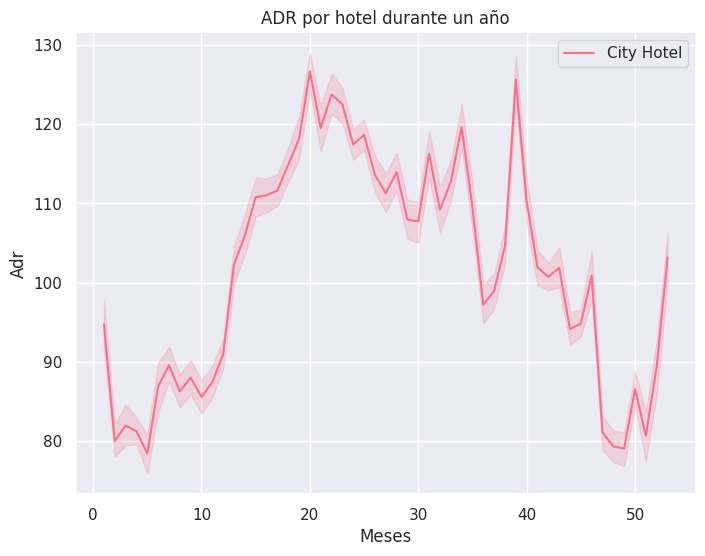

In [829]:
sns.lineplot(df_city_hotel, x="arrival_date_week_number", y="adr")
plt.xlabel("Número de semana")
plt.ylabel("ADR")
plt.title("ADR del hotel City")
plt.show()

Para poder utilizar la función de pandas `interpolate` es necesario que todos los registros de `adr` que sean 0, pasen a tener el valor de `NaN`. Por lo tanto reemplazamos los valores.

In [830]:
df_city_hotel.loc[df_city_hotel.loc[:, 'adr'] == 0, 'interpolate_register'] = 1
df_city_hotel.loc[df_city_hotel.loc[:, 'adr'] == 0, 'adr'] = np.NaN

df_city_hotel['adr_interpolate'] = 0



<ipython-input-830-c1a33d73c353>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-830-c1a33d73c353>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [831]:
df_interpolate_sorted = df_city_hotel.sort_values('arrival_date_week_number')

In [832]:
df_interpolate_sorted[['adr', 'arrival_date_month', 'arrival_date_week_number' ,'adr_interpolate', 'interpolate_register']]

,adr,arrival_date_month,arrival_date_week_number,adr_interpolate,interpolate_register
8152,65.00,Jan,1,0,NaN
17198,104.00,Jan,1,0,NaN
49331,88.29,Jan,1,0,NaN
51907,74.80,Jan,1,0,NaN
49345,109.00,Jan,1,0,NaN
...,...,...,...,...,...
59296,110.80,Jan,53,0,NaN
55259,183.00,Jan,53,0,NaN
53324,70.00,Jan,53,0,NaN
25627,120.00,Jan,53,0,NaN


In [833]:
df_interpolate_sorted.loc[:,'adr_interpolate'] = df_interpolate_sorted['adr'].interpolate(method='linear')

In [834]:
df_interpolate_sorted[df_interpolate_sorted['interpolate_register'] == 1][['adr', 'arrival_date_month', 'arrival_date_week_number' ,'adr_interpolate', 'interpolate_register']]

,adr,arrival_date_month,arrival_date_week_number,adr_interpolate,interpolate_register
47771,NaN,Jan,1,79.355,1.0
43512,NaN,Jan,1,105.195,1.0
4948,NaN,Jan,1,87.900,1.0
36193,NaN,Jan,2,75.000,1.0
219,NaN,Jan,2,91.075,1.0
...,...,...,...,...,...
4698,NaN,Dec,52,86.750,1.0
41794,NaN,Jan,53,112.675,1.0
27210,NaN,Jan,53,141.825,1.0
27128,NaN,Jan,53,73.335,1.0


In [835]:
df_city_hotel['adr'].describe()

count    41451.000000
mean       106.311975
std         37.101373
min          0.500000
25%         79.500000
50%        100.000000
75%        126.000000
max        510.000000
Name: adr, dtype: float64

In [836]:
df_interpolate_sorted['adr_interpolate'].describe()

count    41937.000000
mean       106.272552
std         36.996794
min          0.500000
25%         79.670000
50%        100.000000
75%        126.000000
max        510.000000
Name: adr_interpolate, dtype: float64

In [837]:
df_city_hotel.loc[df_city_hotel.loc[:, 'adr'].isna(), 'adr'] = df_interpolate_sorted['adr_interpolate']

In [838]:
df_city_hotel['adr'].describe()

count    41937.000000
mean       106.272552
std         36.996794
min          0.500000
25%         79.670000
50%        100.000000
75%        126.000000
max        510.000000
Name: adr, dtype: float64

In [839]:
len(df_city_hotel[df_city_hotel['adr'] == 0])

0

Podemos observar que la interpolación reemplazo todos los valores `NaN`

In [840]:
df_hotels_train.loc[(df_hotels_train['hotel'] == "City Hotel") & (df_hotels_train['adr'] == 0), 'adr'] = df_city_hotel['adr']

##### Interpolación para Resort Hotel

In [841]:
df_resort_hotel = df_hotels_train[df_hotels_train['hotel'] == "Resort Hotel"]

df_resort_hotel['adr'].describe()

count    19778.000000
mean        97.144586
std         62.374459
min          0.000000
25%         52.000000
50%         78.000000
75%        129.000000
max        450.000000
Name: adr, dtype: float64

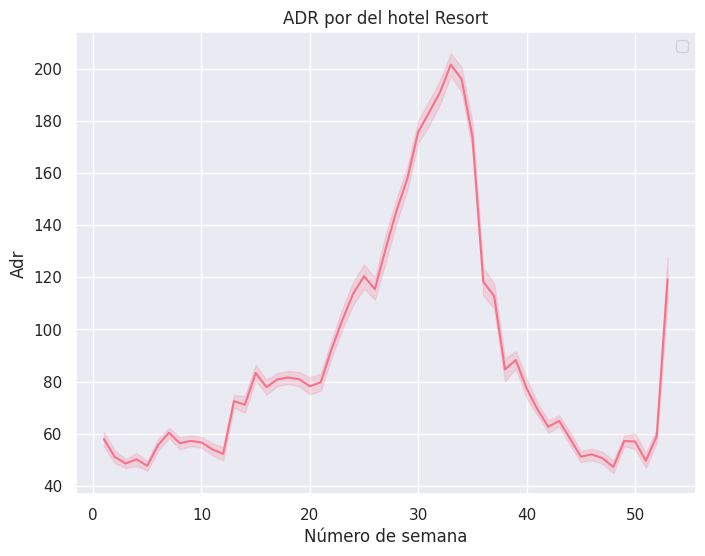

In [913]:
sns.lineplot(df_resort_hotel, x="arrival_date_week_number", y="adr")
plt.xlabel("Número de semana")
plt.ylabel("Adr")
plt.title("ADR por del hotel Resort")
plt.show()

Para poder utilizar la función de pandas `interpolate` es necesario que todos los registros de `adr` que sean 0, pasen a tener el valor de `NaN`. Por lo tanto reemplazamos los valores.

In [843]:
df_resort_hotel.loc[df_resort_hotel.loc[:, 'adr'] == 0, 'interpolate_register'] = 1
df_resort_hotel.loc[df_resort_hotel.loc[:, 'adr'] == 0, 'adr'] = np.NaN

df_resort_hotel['adr_interpolate'] = 0



<ipython-input-843-ee5cf468d686>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-843-ee5cf468d686>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [844]:
df_interpolate_sorted = df_resort_hotel.sort_values('arrival_date_week_number')

In [845]:
df_interpolate_sorted[['adr', 'arrival_date_month', 'arrival_date_week_number' ,'adr_interpolate', 'interpolate_register']]

,adr,arrival_date_month,arrival_date_week_number,adr_interpolate,interpolate_register
54886,88.00,Jan,1,0,NaN
6794,37.80,Jan,1,0,NaN
1502,72.00,Jan,1,0,NaN
23957,87.00,Jan,1,0,NaN
455,119.00,Jan,1,0,NaN
...,...,...,...,...,...
17403,208.33,Jan,53,0,NaN
20735,91.44,Jan,53,0,NaN
35122,107.05,Jan,53,0,NaN
8370,225.00,Jan,53,0,NaN


In [846]:
df_interpolate_sorted.loc[:,'adr_interpolate'] = df_interpolate_sorted['adr'].interpolate(method='linear')

In [847]:
df_interpolate_sorted[df_interpolate_sorted['interpolate_register'] == 1][['adr', 'arrival_date_month', 'arrival_date_week_number' ,'adr_interpolate', 'interpolate_register']]

,adr,arrival_date_month,arrival_date_week_number,adr_interpolate,interpolate_register
14119,NaN,Jan,1,38.470,1.0
36716,NaN,Jan,2,52.500,1.0
43716,NaN,Jan,2,45.085,1.0
12363,NaN,Jan,2,33.800,1.0
34065,NaN,Jan,2,52.500,1.0
...,...,...,...,...,...
48046,NaN,Jan,53,92.635,1.0
16364,NaN,Jan,53,104.335,1.0
17708,NaN,Jan,53,119.550,1.0
6303,NaN,Jan,53,211.550,1.0


In [848]:
df_resort_hotel['adr'].describe()

count    19446.000000
mean        98.803128
std         61.588331
min          1.560000
25%         54.000000
50%         79.000000
75%        130.500000
max        450.000000
Name: adr, dtype: float64

In [849]:
df_interpolate_sorted['adr_interpolate'].describe()

count    19778.000000
mean        98.603238
std         61.390822
min          1.560000
25%         53.877500
50%         79.000000
75%        130.000000
max        450.000000
Name: adr_interpolate, dtype: float64

In [850]:
df_resort_hotel.loc[df_resort_hotel.loc[:, 'adr'].isna(), 'adr'] = df_interpolate_sorted['adr_interpolate']

In [851]:
df_resort_hotel['adr'].describe()

count    19778.000000
mean        98.603238
std         61.390822
min          1.560000
25%         53.877500
50%         79.000000
75%        130.000000
max        450.000000
Name: adr, dtype: float64

In [852]:
len(df_resort_hotel[df_resort_hotel['adr'] == 0])

0

Podemos observar que la interpolación reemplazo todos los valores `NaN`

In [853]:
df_hotels_train.loc[(df_hotels_train['hotel'] == "Resort Hotel") & (df_hotels_train['adr'] == 0), 'adr'] = df_resort_hotel['adr']

##### Análisis finales


In [854]:
describe_pre_imp

count    61715.000000
mean       102.536876
std         47.675970
min          0.000000
25%         70.000000
50%         95.000000
75%        126.000000
max        510.000000
Name: adr, dtype: float64

In [855]:
df_hotels_train['adr'].describe()

count    61715.000000
mean       103.814743
std         46.375439
min          0.500000
25%         71.280000
50%         95.000000
75%        126.000000
max        510.000000
Name: adr, dtype: float64

Actualizar descripción

### Análisis e imputación del country

In [856]:
cantidad_reservas_adr_negativo = len(df_hotels_train[df_hotels_train['country'].isna()])
print(f'Cantidad de reservas con paises nulos: {cantidad_reservas_adr_negativo}')

Cantidad de reservas con paises nulos: 216


Hay 216 reservas que no tienen un pais registrado, en este caso no borraremos los registros, sino que borrarremos la columna, ya que  en base a las correlaciónes y nuestro criterio, es una columna que no aporta información sobre la cancelaciónde la reserva.

In [857]:
df_hotels_train.drop(columns = "country", axis = 0, inplace=True)
df_hotels_test.drop(columns = "country", axis = 0, inplace=True)

In [858]:
df_hotels_train.columns.tolist()

['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_date',
 'id',
 'is_canceled']

### Análisis e imputación de agent y company

Las columnas del agente y compania no proporcionan datos relevantes  para predecir la cancelación de la reserva, por lo tanto, eliminaremos ambas columnas.

In [859]:
df_hotels_train.drop(columns = ["agent", "company"], axis = 0, inplace=True)
df_hotels_test.drop(columns = ["agent", "company"], axis = 0, inplace=True)

In [860]:
df_hotels_train.columns.tolist()

['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_date',
 'id',
 'is_canceled']

### Análisis e imputación de childrens

In [861]:
cantidad_hijos_nulos = df_hotels_train['children'].isnull().sum()
print(f'Cantidad de reservas con children nulo: {cantidad_hijos_nulos}')

Cantidad de reservas con children nulo: 4


In [862]:
df_hotels_train.loc[df_hotels_train['children'].isna(), 'children'] = 0

In [863]:
tipo_dato_children = df_hotels_train['children'].dtype
print(f'Tipo de dato de la columna children: {tipo_dato_children}')

Tipo de dato de la columna children: float64


Podemos observar que children es del tipo `float64` lo cual carece de sentido, por lo tanto se lo transformara a `int`

In [864]:
df_hotels_train['children'].isna().sum()

0

In [865]:
df_hotels_train['children'] = df_hotels_train['children'].astype(int)

In [866]:
tipo_dato_children = df_hotels_train['children'].dtype
print(f'Tipo de dato de la columna children: {tipo_dato_children}')

Tipo de dato de la columna children: int64


In [867]:
df_hotels_train[df_hotels_train['children'].isna()]

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled


Podemos observar que hay 4 registros que son NaN, lo cual no tiene sentido y el tipo de dato afectará a futuros análisis, por lo tanto reemplazaremos los valores con 0.


In [868]:
df_hotels_train['children'].fillna(0, inplace=True)

In [869]:
len(df_hotels_train[df_hotels_train['children'].isna()])

0

### Análisis e imputación de meals

Segun el paper, SC y Undefined, representan lo mismo, por lo tanto decidimos en reemplazar los Undefined por SC. Esto puede ser beneficioso para el encoding a la hora de entrenar los modelos ya que seria una variable menos.

In [870]:
cantidad_undefined = len(df_hotels_train[df_hotels_train['meal'] == "Undefined"])
print(f'Cantidad de reservas con meal Undefined: {cantidad_undefined}')

Cantidad de reservas con meal Undefined: 591


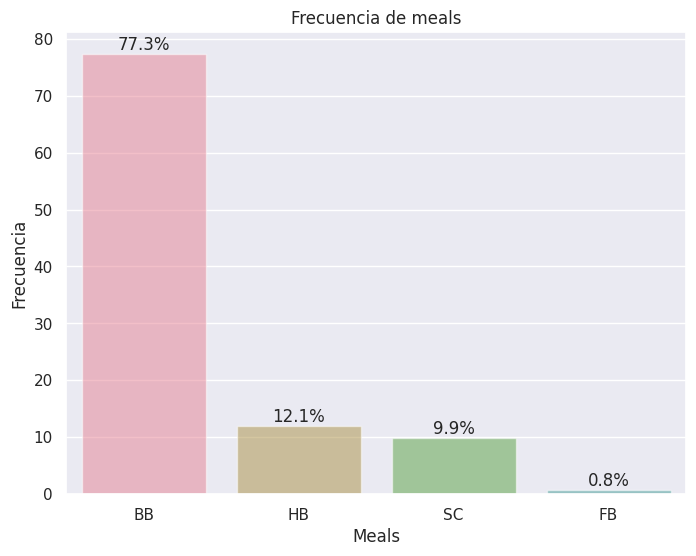

In [914]:
showBarPlot('meal', "Frecuencia de meals", x_label= 'Meals', y_label="Frecuencia", showPercentage = True)

In [872]:
df_hotels_train.loc[df_hotels_train['meal'] == "Undefined", 'meal'] = "SC"

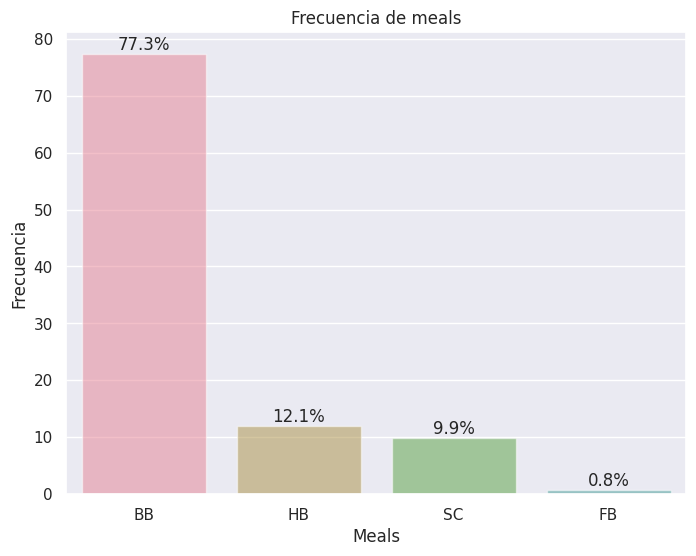

In [915]:
showBarPlot('meal', "Frecuencia de meals", x_label= 'Meals', y_label="Frecuencia", showPercentage = True)

Podemos observar que, con la unificación, ahora el valor "SC" obtuvo el 1% que tenía el "Undefined".

## Valores atípicos

El análisis de outliers se recomienda realizar en variables numéricas continuas, ya que es más fácil identificar y cuantificar los valores que se alejan significativamente del resto de la distribución.

En cuanto al análisis univariado, se puede utilizar el boxplot para identificar valores atípicos en cada variable por separado. Para el análisis multivariado, se pueden utilizar técnicas como el análisis de correlación y la regresión lineal para identificar si hay una relación entre las variables y si alguna de ellas influye en la presencia de valores atípicos en las demás.

### Análisis univariado


#### Variables cuantitativas

Para este tipo de variables, podemos analizar los valores atipicos con un diagrama de boxplot. Tambien se utilizaran el _z-score_ para su análisis.

##### lead_time

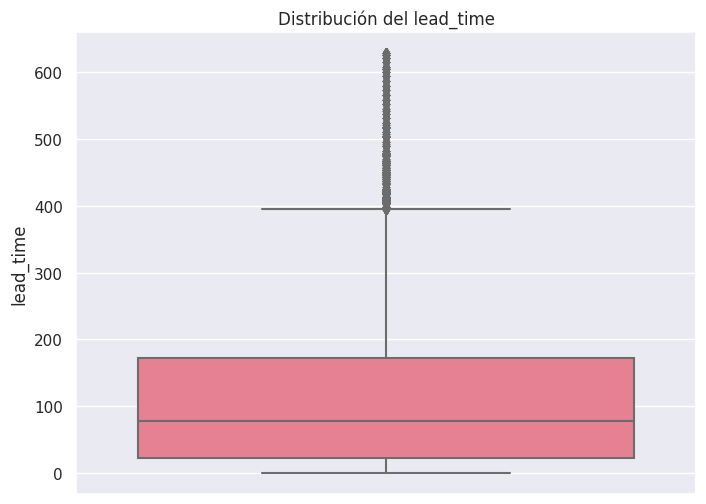

In [916]:
sns.boxplot(y=df_hotels_train['lead_time']).set(title="Distribución del lead_time")
plt.show()

In [876]:
Q1_altura=np.quantile(df_hotels_train['lead_time'],0.25)
Q3_altura=np.quantile(df_hotels_train['lead_time'],0.75)

#Rango intercuartil
IQR_altura=Q3_altura-Q1_altura

#Limite inferior Outliers
out_inf=Q1_altura-1.5*IQR_altura
out_sup=Q3_altura+1.5*IQR_altura
print(out_inf)
print(out_sup)

-200.5
395.5


In [877]:
cantidad = len(df_hotels_train[df_hotels_train['lead_time'] > out_sup].index)
porcentaje = round(cantidad * 100 / len(df_hotels_train), 2)
print(f'Porcentaje de reservas con lead_time mayores a 1 año: {porcentaje}%\nCantidad: {cantidad}')

Porcentaje de reservas con lead_time mayores a 1 año: 2.22%
Cantidad: 1368


Vamos a calcular su z_score_mod para poder analizar mejor los outliers


In [878]:
df_hotels_score = df_hotels_train.copy()
mediana_lead_time=np.median(df_hotels_score['lead_time'])
MAD=np.median(np.absolute(df_hotels_score['lead_time']-mediana_lead_time))

df_hotels_score['zm_lead_time']=(df_hotels_score['lead_time'] - mediana_lead_time)*0.6745/MAD

In [879]:
df_hotels_score.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled,zm_lead_time
0,City Hotel,49,2016,Sep,37,5,1,2,1,0,...,No Deposit,0,Transient,115.5,0,1,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1,-0.300931
1,Resort Hotel,4,2015,Nov,44,31,0,1,2,0,...,No Deposit,0,Transient,42.0,1,0,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0,-0.767892
2,City Hotel,25,2016,Oct,42,13,0,1,2,2,...,No Deposit,0,Transient,229.0,0,2,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0,-0.549977
3,City Hotel,26,2016,Dec,51,12,2,5,2,0,...,Non Refund,0,Transient,75.0,0,0,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1,-0.539600
4,City Hotel,104,2017,Mar,12,19,2,5,2,0,...,No Deposit,0,Transient-Party,75.0,0,1,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0,0.269800


In [880]:
cantidad  = len(df_hotels_score[df_hotels_score['zm_lead_time'] < -3.5])
print(f'Cantidad con un z-score menor al -3.5: {cantidad}')

Cantidad con un z-score menor al -3.5: 0


In [881]:
cantidad = len(df_hotels_score[df_hotels_score['zm_lead_time'] > 3.5].index)
porcentaje = round(cantidad * 100 / len(df_hotels_score), 2)
print(f'Porcentaje de reservas con z-score modificado mayores a 3.5: {porcentaje}%\nCantidad: {cantidad}')

Porcentaje de reservas con z-score modificado mayores a 3.5: 1.75%
Cantidad: 1078


Podemos observar que la cantidad de reservas que su z-score para el lead_time supera el 3.5, es una población reducida, por lo tanto se puede tener en cuenta la eliminación de los mismos.

##### adr

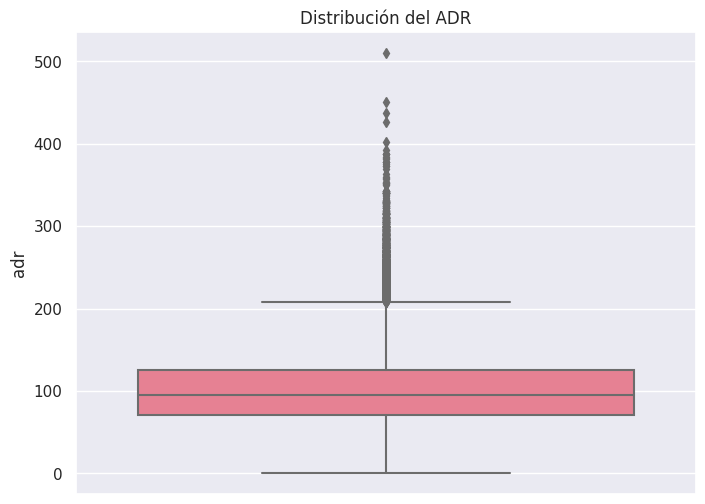

In [917]:
sns.boxplot(y=df_hotels_train['adr']).set(title="Distribución del ADR")
plt.show()

In [883]:
df_hotels_train[df_hotels_train['adr'].isna()]

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled


In [884]:
Q1_altura=np.quantile(df_hotels_train['adr'],0.25)
Q3_altura=np.quantile(df_hotels_train['adr'],0.75)

#Rango intercuartil
IQR_altura=Q3_altura-Q1_altura

#Limite inferior Outliers
out_inf=Q1_altura-1.5*IQR_altura
out_sup=Q3_altura+1.5*IQR_altura

In [885]:
cantidad = len(df_hotels_train[df_hotels_train['adr'] > out_sup].index)
porcentaje = round(cantidad / len(df_hotels_train) * 100, 2)

print(f'Porcentaje de reservas con adr mayores a 210: {porcentaje} \nCantidad: {cantidad}')

Porcentaje de reservas con adr mayores a 210: 3.56 
Cantidad: 2200


Representan un número  "alto" de la población, no sé que tanto conviene sacarlos porque hay que recordar que el precio variaba mucho dependiendo del hotel y de la temporada, tal vez la mejor decisión sea dejarlos.

In [886]:
mediana_adr=np.median(df_hotels_score['adr'])
MAD=np.median(np.absolute(df_hotels_score['adr']-mediana_adr))

df_hotels_score['zm_adr']=(df_hotels_score['adr'] - mediana_adr)*0.6745/MAD

In [887]:
cantidad  = len(df_hotels_score[df_hotels_score['zm_adr'] < -3.5])
print(f'Cantidad con un z-score menor al -3.5: {cantidad}')

Cantidad con un z-score menor al -3.5: 0


In [888]:
cantidad = len(df_hotels_score[df_hotels_score['zm_adr'] > 3.5].index)
porcentaje = round(cantidad * 100 / len(df_hotels_score), 2)
print(f'Porcentaje de reservas con z-score modificado mayores a 3.5: {porcentaje}%\nCantidad: {cantidad}')

Porcentaje de reservas con z-score modificado mayores a 3.5: 1.66%
Cantidad: 1026


##### children y babies

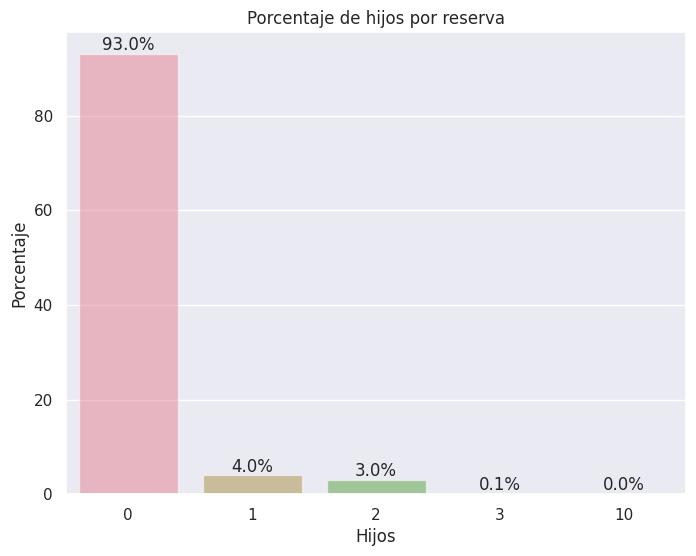

In [919]:

showBarPlot('children', "Porcentaje de hijos por reserva", x_label= 'Hijos', y_label="Porcentaje", showPercentage = True)

En la mayoría de reservas no se registran hijos, pero hay casos que hay más de 5 hijos, consideraremos las reservas que tienen más de 5 hijos como un outlier.

In [890]:
cantidad = len(df_hotels_train[df_hotels_train['children'] > 5].index)
porcentaje = cantidad / len(df_hotels_train) * 100

print(f'Porcentaje de reservas con adr mayores a {5}: {porcentaje}% \nCantidad: {cantidad}')

Porcentaje de reservas con adr mayores a 5: 0.0016203516163007373% 
Cantidad: 1


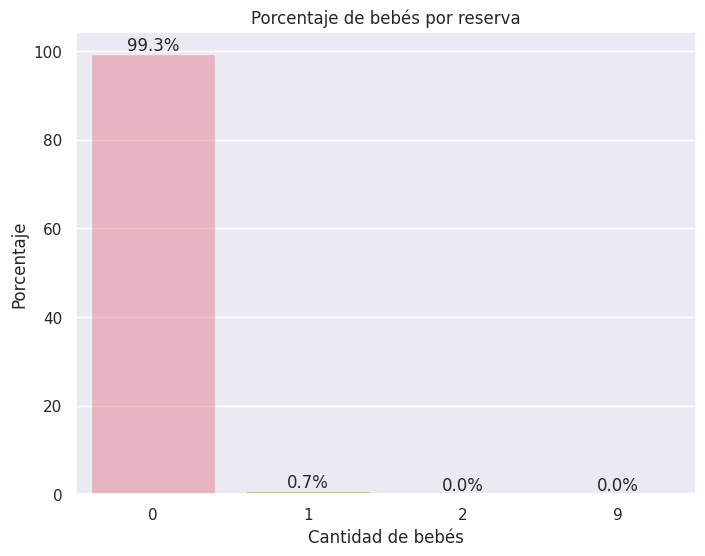

In [920]:
showBarPlot('babies', "Porcentaje de bebés por reserva", x_label= 'Cantidad de bebés', y_label="Porcentaje", showPercentage = True)

In [921]:
cantidad = len(df_hotels_train[df_hotels_train['babies'] > 5].index)
porcentaje = cantidad / len(df_hotels_train) * 100

print(f'Porcentaje de reservas con más de {5} bebes: {porcentaje}% \nCantidad: {cantidad}')

Porcentaje de reservas con más de 5 bebes: 0.0016203516163007373% 
Cantidad: 1


##### week and weekend days

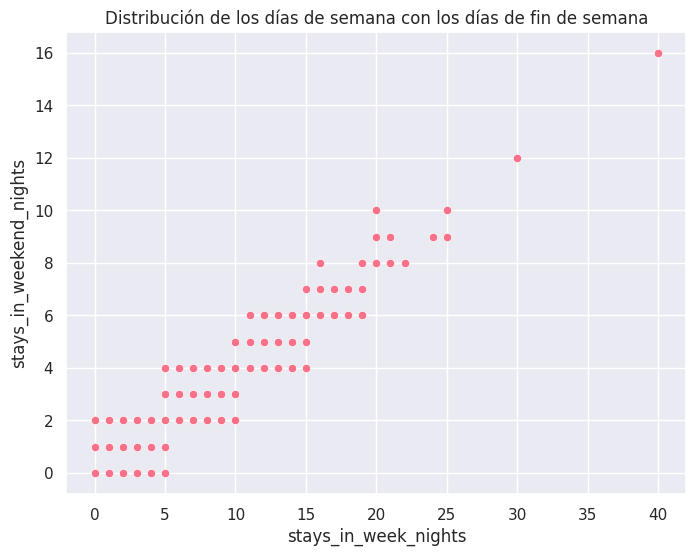

In [922]:
sns.scatterplot(y=df_hotels_train['stays_in_weekend_nights'], x = df_hotels_train['stays_in_week_nights']).set(title="Distribución de los días de semana con los días de fin de semana")
plt.show()

Observamos que hay una reserva que se quedo 40 noches de semana y 16 días de fin de semana. No lo consideramos outlier ya que se complementan.

##### market segment y distribution channel

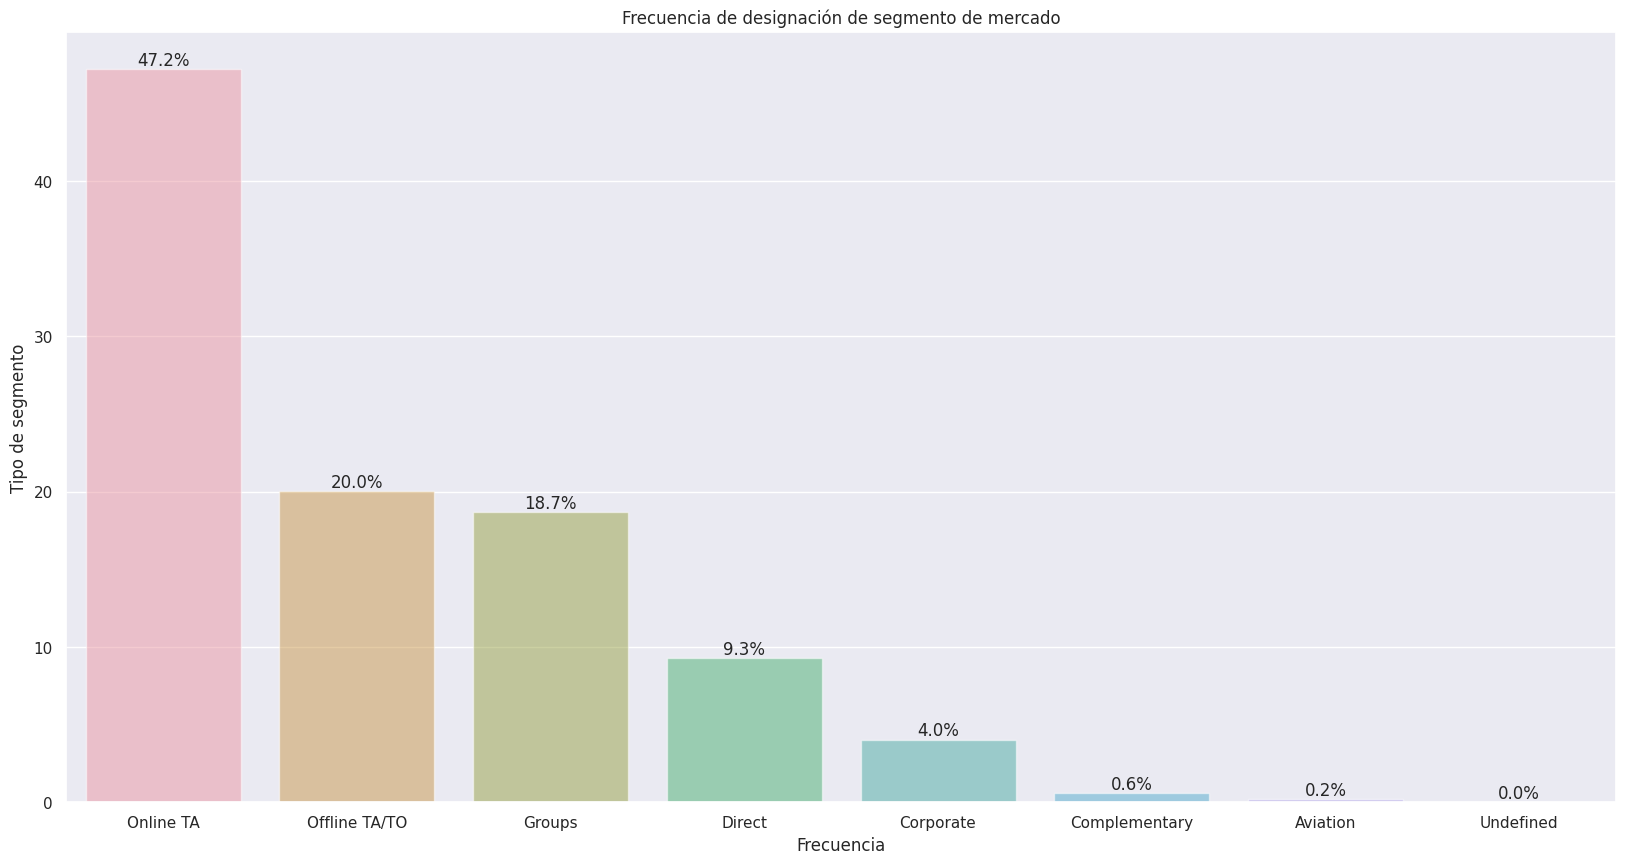

In [925]:
plt.figure(figsize = (20,10))
showBarPlot('market_segment', "Frecuencia de designación de segmento de mercado", x_label= 'Frecuencia', y_label="Tipo de segmento", showPercentage = True)

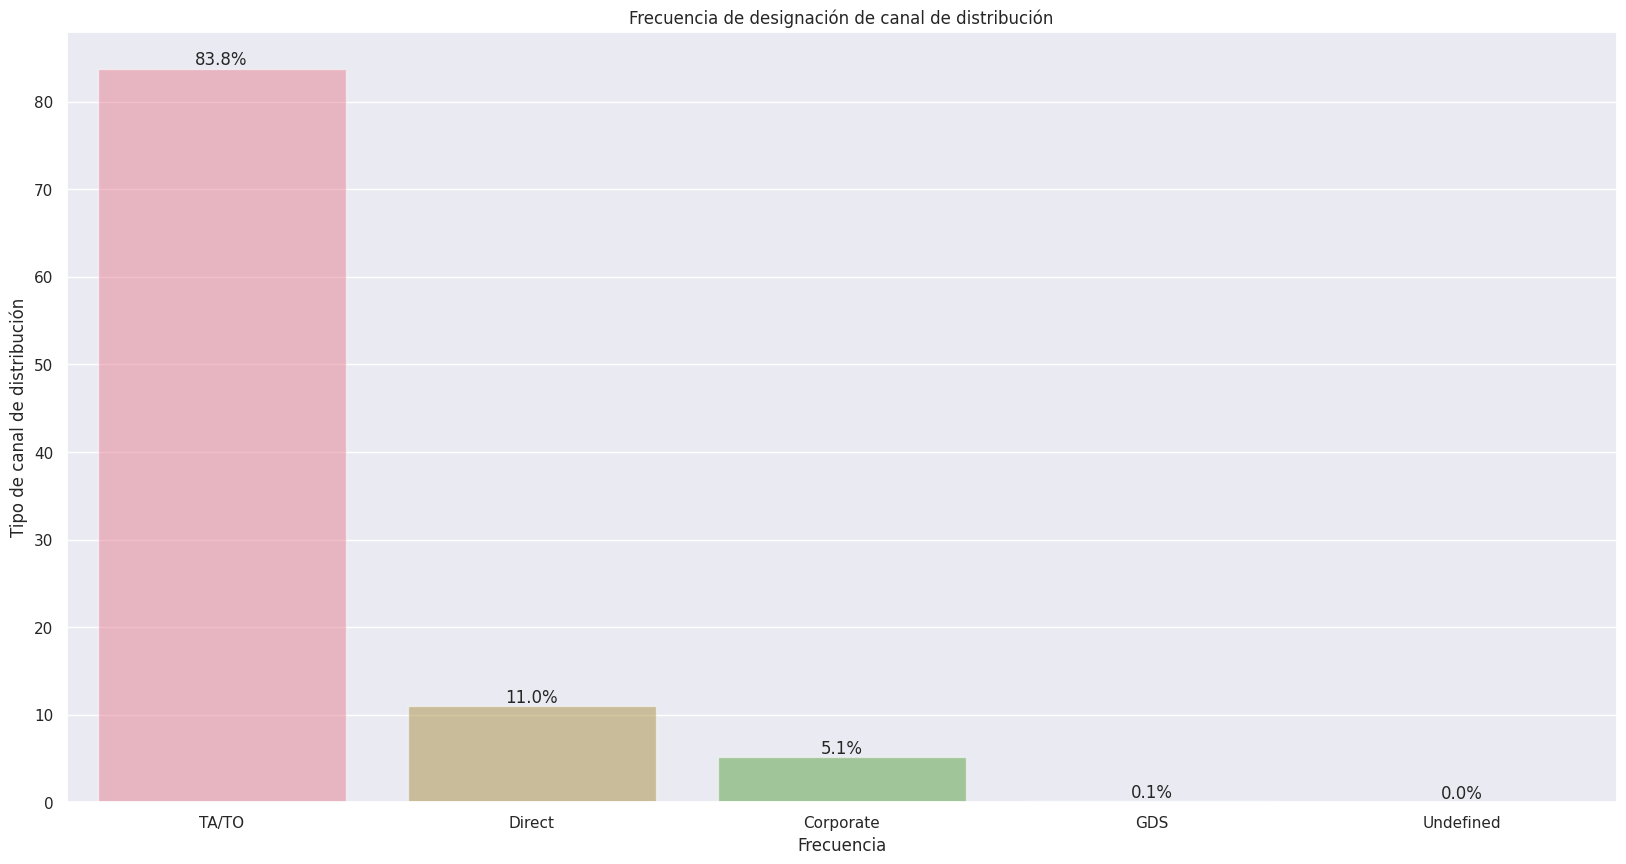

In [927]:
plt.figure(figsize = (20,10))
showBarPlot('distribution_channel', "Frecuencia de designación de canal de distribución", x_label= 'Frecuencia', y_label="Tipo de canal de distribución", showPercentage = True)

In [896]:
cantidad = len(df_hotels_train[df_hotels_train['market_segment'] == "Undefined"].index)
porcentaje = cantidad / len(df_hotels_train) * 100

print(f'Porcentaje de reservas con market_segment Undefined: {porcentaje}% \nCantidad: {cantidad}')

cantidad = len(df_hotels_train[df_hotels_train['distribution_channel'] == "Undefined"].index)
porcentaje = cantidad / len(df_hotels_train) * 100

print(f'Porcentaje de reservas con distribution_channel Undefined: {porcentaje}% \nCantidad: {cantidad}')

Porcentaje de reservas con market_segment Undefined: 0.0032407032326014747% 
Cantidad: 2
Porcentaje de reservas con distribution_channel Undefined: 0.006481406465202949% 
Cantidad: 4


Basandonos en el paper del dataset, *2. Experimental design, materials and methods*. Dicha sección nos explica sobre que las variables categoricas que contengan `Null` o `Undefined` no podrían ser tratados como datos faltantes o mal ingresados, sino como un valor posible. Cómo por ejemplo, la variable `agent` puede ser nulo, pero eso no significa que este mal, sino que la reserva no proviene de un agente.

En conclusión, no borraremos estos registros.

##### previous cancellations

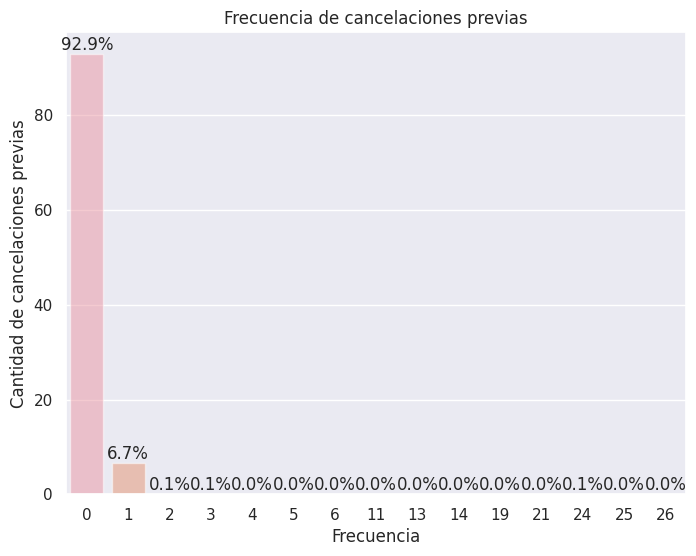

In [928]:
showBarPlot('previous_cancellations', "Frecuencia de cancelaciones previas", x_label= 'Frecuencia', y_label="Cantidad de cancelaciones previas", showPercentage = True)

In [929]:
cantidad = len(df_hotels_train[df_hotels_train['previous_cancellations'] == 26].index)
porcentaje = cantidad / len(df_hotels_train) * 100

print(f'Porcentaje de reservas con market_segment Undefined: {porcentaje}% \nCantidad: {cantidad}')

Porcentaje de reservas con market_segment Undefined: 0.032407032326014745% 
Cantidad: 20


 no lo sacamos por el paper (hacer más lindo esta explicación)

### Análisis multivariado


#### Adultos con tipo de cliente

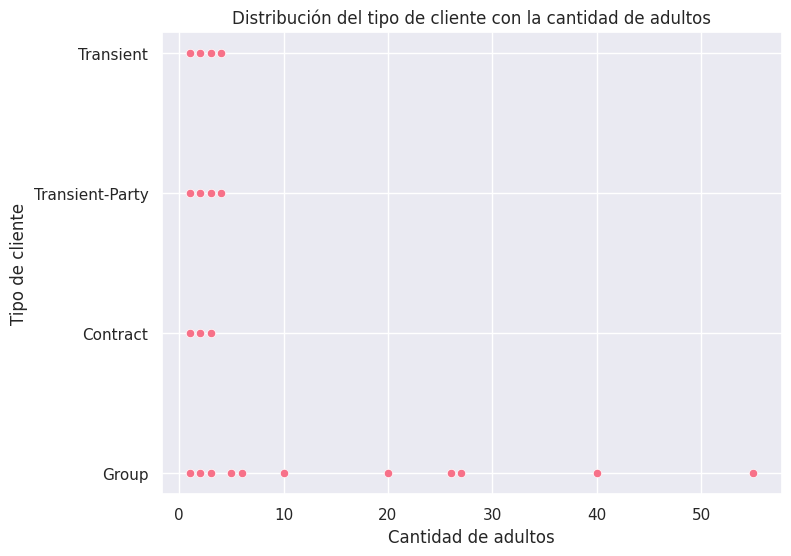

In [930]:
sns.scatterplot(x=df_hotels_train['adults'], y = df_hotels_train['customer_type']).set(title ="Distribución del tipo de cliente con la cantidad de adultos", xlabel="Cantidad de adultos", ylabel="Tipo de cliente")
plt.show()

Existen reservas en las que se registraron más de 30 adultos, pero como son del tipo "Grupo" no va a ser considerada outlier.

#### ADR con cantidad de pedidos especiales

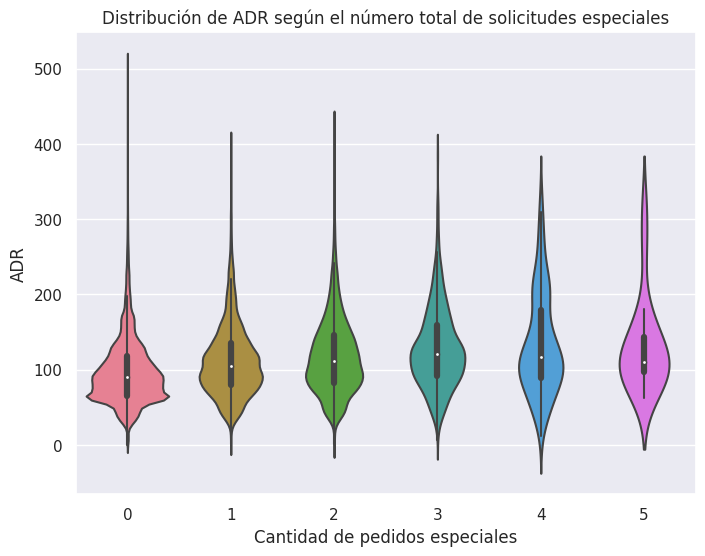

In [931]:
sns.violinplot(x='total_of_special_requests', y='adr', data=df_hotels_train).set(title="Distribución de ADR según el número total de solicitudes especiales", xlabel="Cantidad de pedidos especiales", ylabel="ADR")
plt.show()